In [1]:
import csv
from pathlib import Path
import os

def write_to_csv_parameters(filename):
    fieldnames = ['Date', 'Item Name', 'p', 'd', 'q']
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # Write header row
        writer.writerow(fieldnames)
        
        # writer.writerow([today_date, product_name, p, d, q])
        
base_dir = Path(os.getenv("BASE_DIRECTORY"))
filename = base_dir / "ml_models/vegetables_saved_models/vegetables_parameters.csv"
write_to_csv_parameters(filename)

         Date Item Name  Low Price  Average Price  High Price
0  02-12-2024     ટમેટા        600          800.0        1000
1  02-12-2024      મરચા        500          750.0        1000
2  02-12-2024     ગુવાર        800         1100.0        1400
3  02-12-2024      કોબી        300          350.0         400
4  02-12-2024      દુધી         80          130.0         180
['ટમેટા' 'મરચા' 'ગુવાર' 'કોબી' 'દુધી' 'ફલાવર' 'કાકડી' 'રીંગણા' 'ભીંડો'
 'ગલકા' 'ગાજર' 'ટિંડોરા' 'તુવેર' 'વાલ' 'વટાણા' 'શક્કરીયા' 'બટેટા' 'અંબાળા'
 'લીલી હળદર' 'ડુંગળી પુરા' 'તાંજરીયા પુરા' 'કોથમીર પુરા' 'મૂળા પુરા'
 'ફોદીનો પુરા' 'ચૂ્રણ' 'ઘીસોડા' 'લીંબુ' 'મેથી પુરા' 'બીટ પુરા'
 'સરગવો પુરા' 'ચોરા' 'કારેલા' 'વાલોર' 'કાચા પોપૈયા' 'આદુ' 'મકાઈ ડોડા'
 'લસણ પુરા' 'પાલક પુરા' 'કેરી કાચી' 'કાચા કેળા' 'પચકારુ' 'ફણશી' 'parvar'
 'ratalu gajar' 'લીમડો પુરા' 'શેરડી' 'મગફળી લીલી' 'ગુંદા' 'લીલા ચણા'
 'alavipan' 'fansh']
Data older than 03-12-2024 has been removed.
ટમેટા size:  110
True
Checking stationarity for the raw price data of ટમ

<Figure size 1200x600 with 0 Axes>

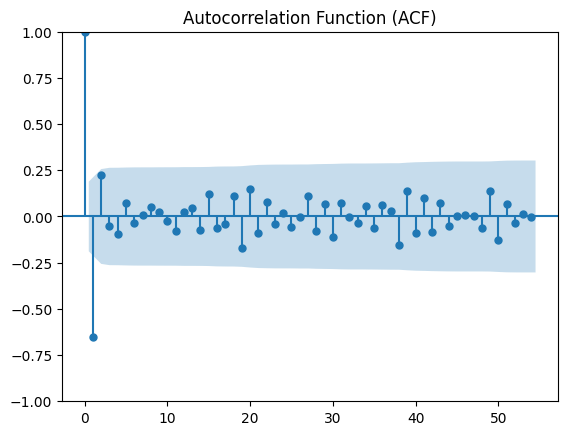

<Figure size 1200x600 with 0 Axes>

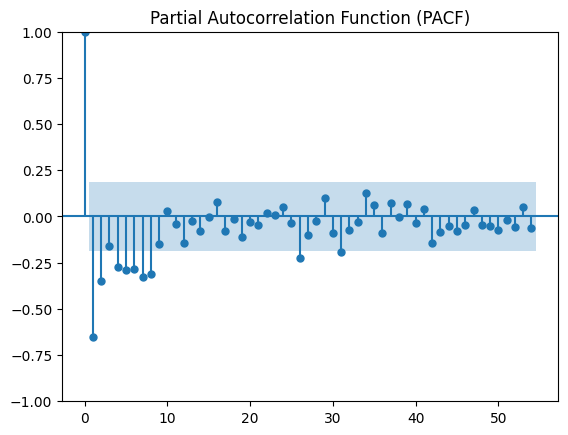


Fitting ARIMA model with order (2, 2, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -568.795
Date:                Wed, 02 Apr 2025   AIC                           1147.591
Time:                        16:05:25   BIC                           1161.001
Sample:                             0   HQIC                          1153.028
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2978      0.080      3.740      0.000       0.142       0.454
ar.L2          0.1033      0.088      1.172      0.241      -0.069       0.2

<Figure size 1200x600 with 0 Axes>

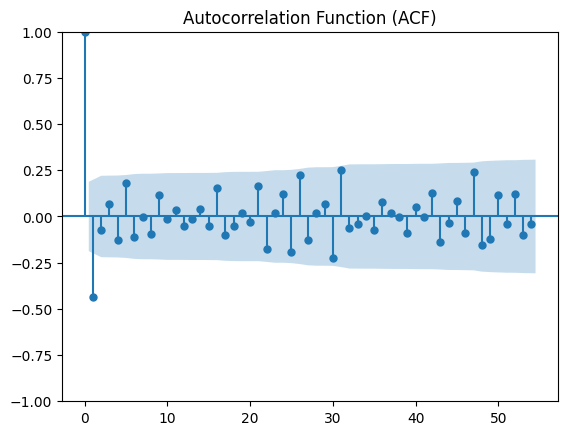

<Figure size 1200x600 with 0 Axes>

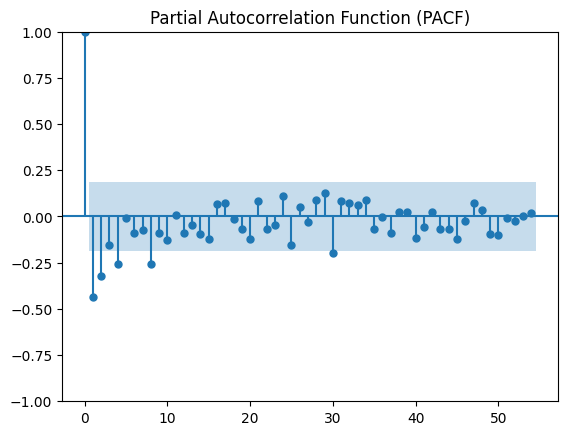


Fitting ARIMA model with order (2, 1, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -654.842
Date:                Wed, 02 Apr 2025   AIC                           1319.684
Time:                        16:05:25   BIC                           1333.141
Sample:                             0   HQIC                          1325.141
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7730      0.196     -3.943      0.000      -1.157      -0.389
ar.L2         -0.0203      0.14

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)



ADF Test Results:
ADF Statistic: -2.4925
p-value: 0.1173
Critical Value 1%: -3.4936
Critical Value 5%: -2.8892
Critical Value 10%: -2.5815
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -5.6341
p-value: 0.0000
Critical Value 1%: -3.4955
Critical Value 5%: -2.8900
Critical Value 10%: -2.5820
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -5.6341
p-value: 0.0000
Critical Value 1%: -3.4955
Critical Value 5%: -2.8900
Critical Value 10%: -2.5820
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 5 at lags [ 1  6  8 12 19]
Significant spikes in PACF (p): 9 at lags [ 1  2  3  6  8 12 13 16 20]


<Figure size 1200x600 with 0 Axes>

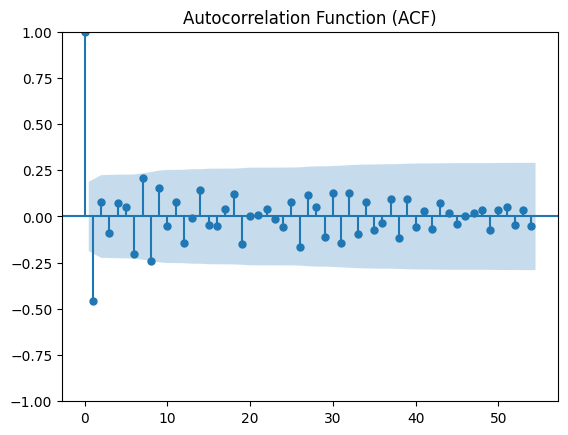

<Figure size 1200x600 with 0 Axes>

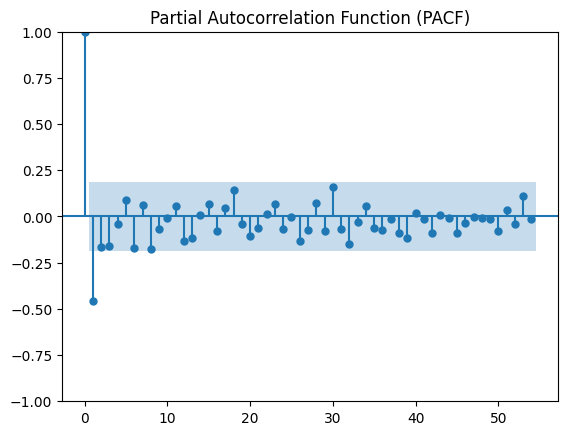


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -706.372
Date:                Wed, 02 Apr 2025   AIC                           1434.744
Time:                        16:05:27   BIC                           1464.348
Sample:                             0   HQIC                          1446.749
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5808      0.244     -2.381      0.017      -1.059      -0.103
ar.L2         -0.2233      0.233     -0.957      0.338      -0.681       0.2

<Figure size 1200x600 with 0 Axes>

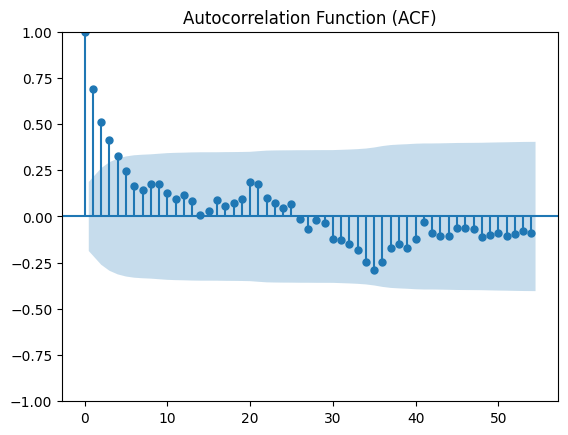

<Figure size 1200x600 with 0 Axes>

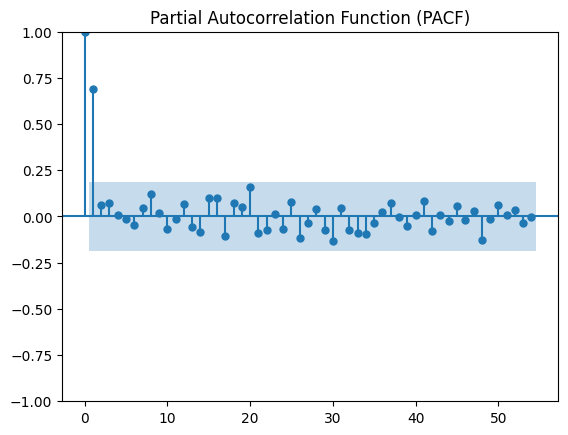


Fitting ARIMA model with order (2, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -607.962
Date:                Wed, 02 Apr 2025   AIC                           1223.923
Time:                        16:05:27   BIC                           1234.725
Sample:                             0   HQIC                          1228.305
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        151.6219     26.982      5.619      0.000      98.739     204.505
ar.L1          0.6358      0.11

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for કોબી saved as D:\APMC-price-predictor\ml_models\vegetables_saved_models\arima_model_952a71343bca62e6737a30576a86347b.pkl
દુધી size:  110
True
Checking stationarity for the raw price data of દુધી:

ADF Test Results:
ADF Statistic: -2.5725
p-value: 0.0988
Critical Value 1%: -3.4961
Critical Value 5%: -2.8903
Critical Value 10%: -2.5821
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -6.0063
p-value: 0.0000
Critical Value 1%: -3.4968
Critical Value 5%: -2.8906
Critical Value 10%: -2.5823
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -6.0063
p-value: 0.0000
Critical Value 1%: -3.4968
Critical Value 5%: -2.8906
Critical Value 10%: -2.5823
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 5 at lags [ 1  2  7 11 15]
Significant spikes in PACF (p): 8 at lags [ 1  2  3  7  8 12 18

<Figure size 1200x600 with 0 Axes>

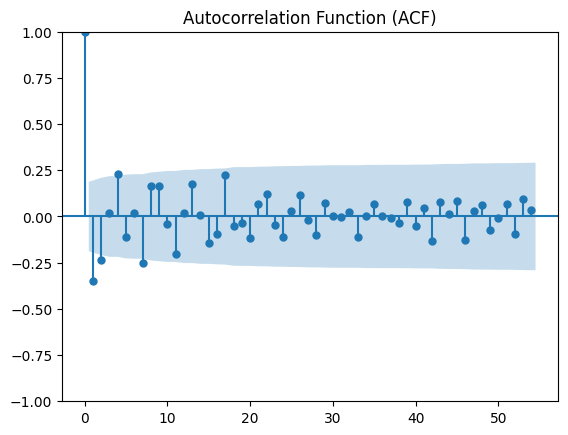

<Figure size 1200x600 with 0 Axes>

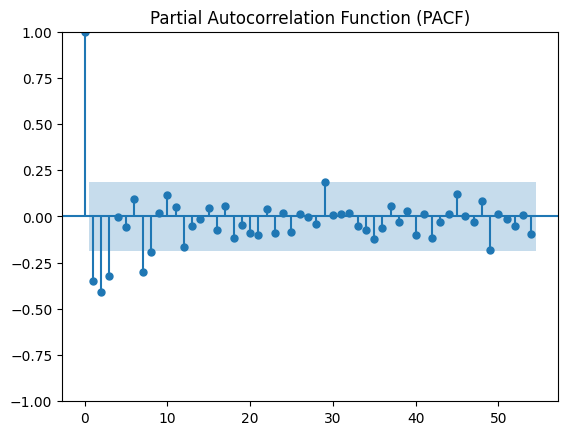


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -521.055
Date:                Wed, 02 Apr 2025   AIC                           1064.109
Time:                        16:05:29   BIC                           1093.714
Sample:                             0   HQIC                          1076.115
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9369      0.220     -4.250      0.000      -1.369      -0.505
ar.L2         -0.5369      0.334     -1.607      0.108      -1.192       0.1

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

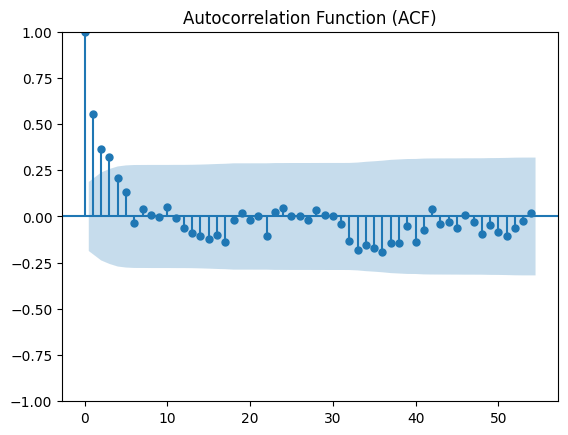

<Figure size 1200x600 with 0 Axes>

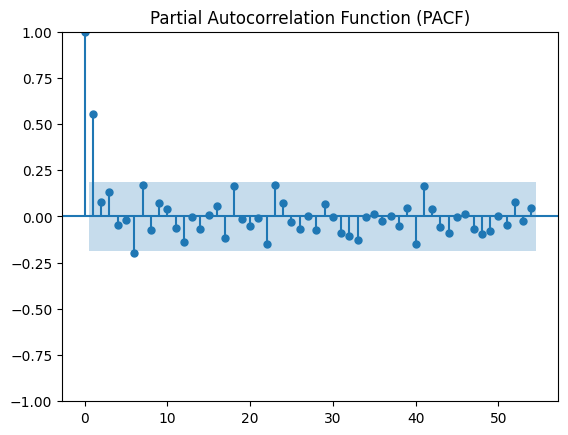


Fitting ARIMA model with order (3, 0, 0)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -740.375
Date:                Wed, 02 Apr 2025   AIC                           1490.751
Time:                        16:05:30   BIC                           1504.253
Sample:                             0   HQIC                          1496.227
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        397.3088     71.331      5.570      0.000     257.502     537.116
ar.L1          0.4864      0.124      3.908      0.000       0.242       0.7

<Figure size 1200x600 with 0 Axes>

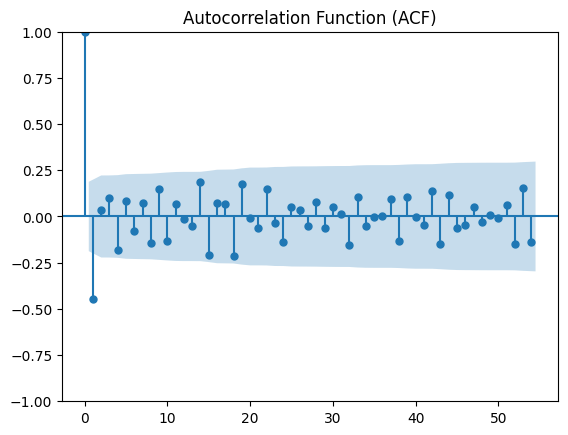

<Figure size 1200x600 with 0 Axes>

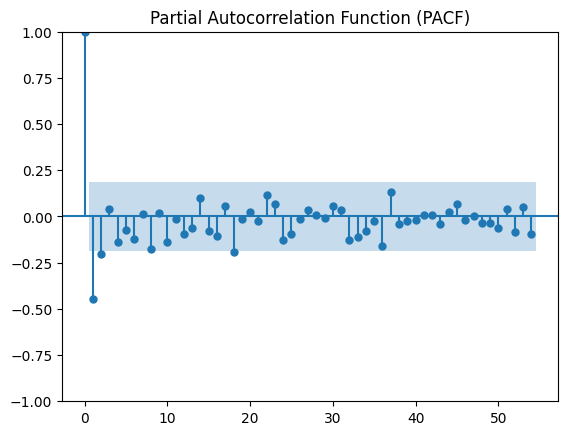


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -621.306
Date:                Wed, 02 Apr 2025   AIC                           1264.613
Time:                        16:05:31   BIC                           1294.218
Sample:                             0   HQIC                          1276.619
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8258      0.668     -1.236      0.216      -2.135       0.484
ar.L2         -0.3756      0.778     -0.483      0.629      -1.901       1.1

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

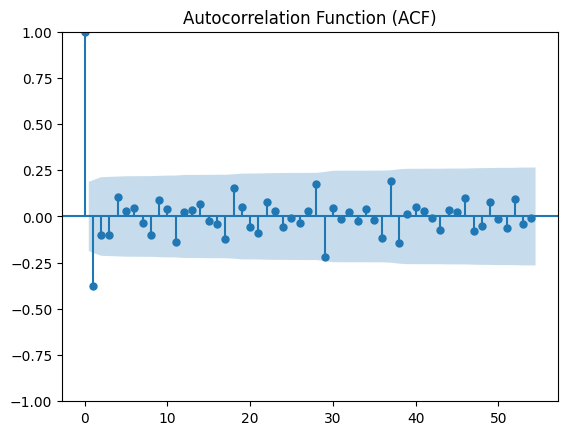

<Figure size 1200x600 with 0 Axes>

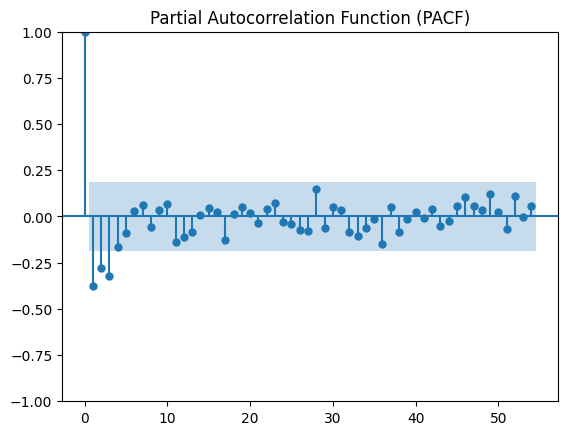


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -557.596
Date:                Wed, 02 Apr 2025   AIC                           1129.192
Time:                        16:05:33   BIC                           1148.031
Sample:                             0   HQIC                          1136.832
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0497      0.579      0.086      0.932      -1.085       1.185
ar.L2         -0.1675      0.553     -0.303      0.762      -1.251       0.9

<Figure size 1200x600 with 0 Axes>

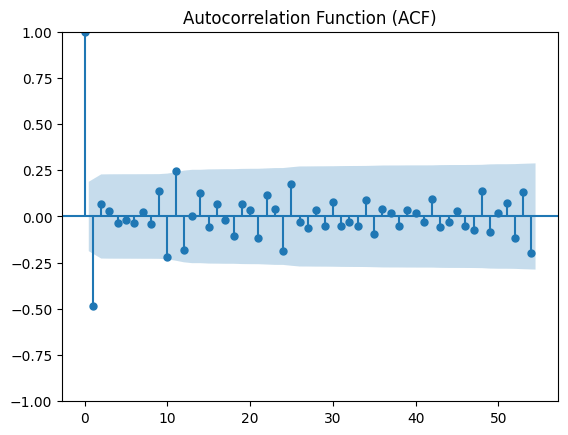

<Figure size 1200x600 with 0 Axes>

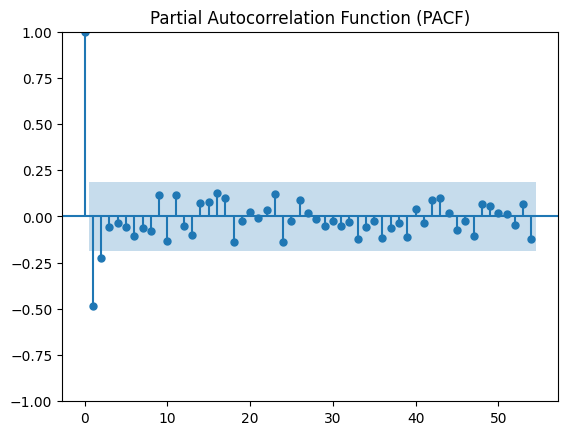


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -637.076
Date:                Wed, 02 Apr 2025   AIC                           1288.152
Time:                        16:05:34   BIC                           1306.991
Sample:                             0   HQIC                          1295.792
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2795      0.326     -0.857      0.391      -0.919       0.360
ar.L2          0.8041      0.158      5.075      0.000       0.494       1.1

<Figure size 1200x600 with 0 Axes>

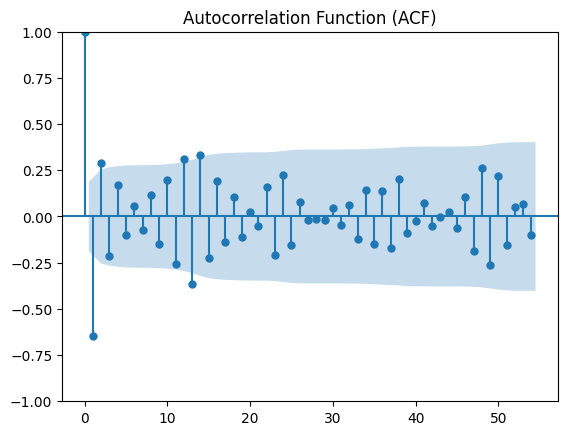

<Figure size 1200x600 with 0 Axes>

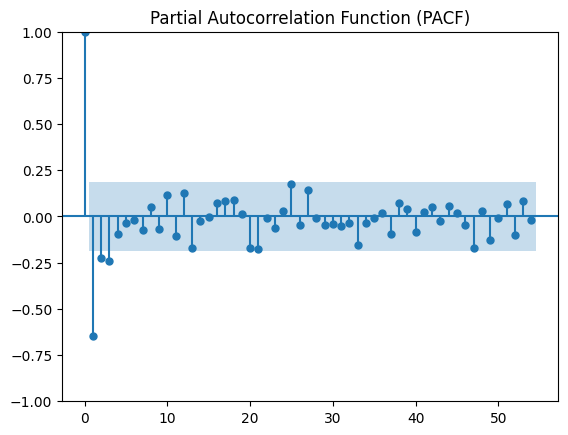


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -596.629
Date:                Wed, 02 Apr 2025   AIC                           1215.258
Time:                        16:05:37   BIC                           1244.863
Sample:                             0   HQIC                          1227.264
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5636      0.291      1.936      0.053      -0.007       1.134
ar.L2          0.2325      0.139      1.667      0.096      -0.041       0.5

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

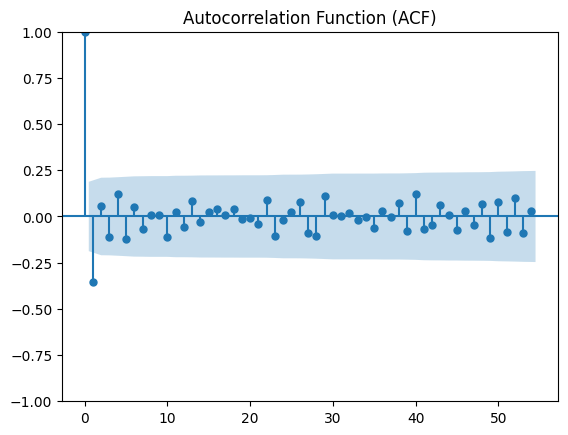

<Figure size 1200x600 with 0 Axes>

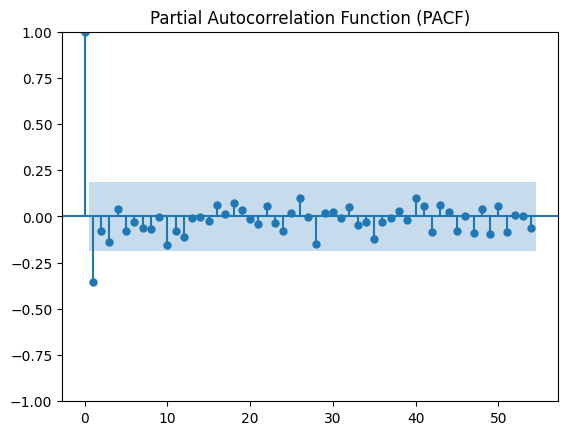


Fitting ARIMA model with order (4, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -580.553
Date:                Wed, 02 Apr 2025   AIC                           1179.107
Time:                        16:05:40   BIC                           1203.329
Sample:                             0   HQIC                          1188.930
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1926      4.335     -0.275      0.783      -9.688       7.303
ar.L2         -0.1356      7.784     -0.017      0.986     -15.391      15.1

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

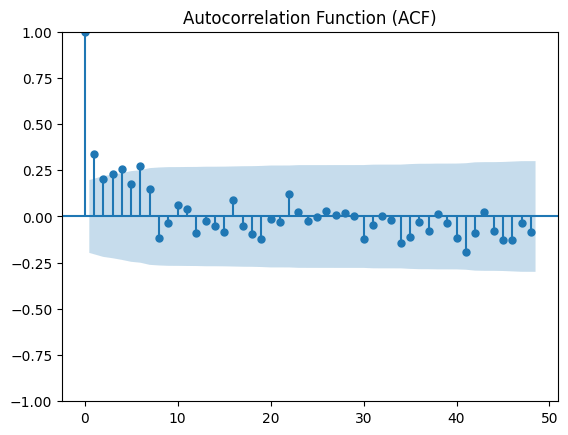

<Figure size 1200x600 with 0 Axes>

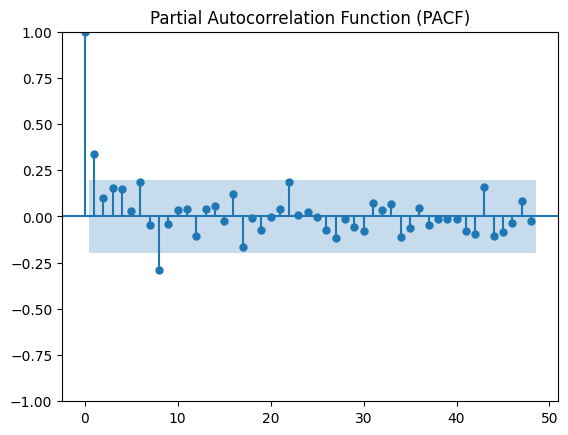


Fitting ARIMA model with order (3, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   99
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -573.192
Date:                Wed, 02 Apr 2025   AIC                           1156.384
Time:                        16:05:41   BIC                           1169.360
Sample:                             0   HQIC                          1161.634
                                 - 99                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        485.9596     19.139     25.392      0.000     448.449     523.471
ar.L1          0.2923      0.13

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


<Figure size 1200x600 with 0 Axes>

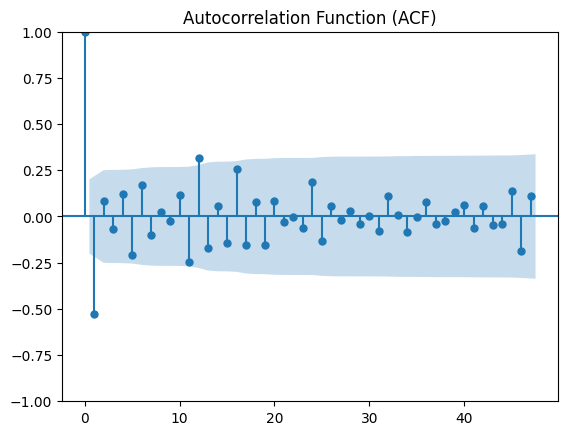

<Figure size 1200x600 with 0 Axes>

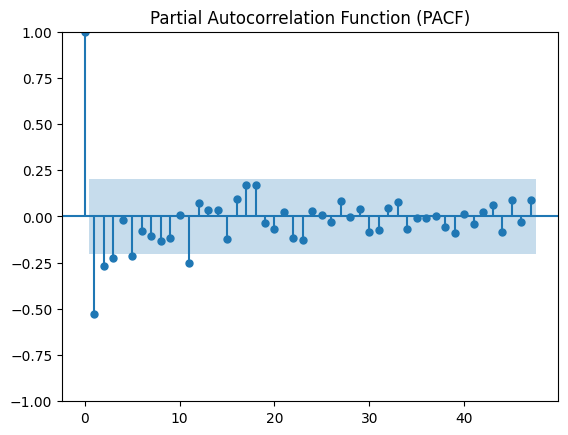


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   96
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -563.825
Date:                Wed, 02 Apr 2025   AIC                           1149.650
Time:                        16:05:43   BIC                           1177.743
Sample:                             0   HQIC                          1161.001
                                 - 96                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4114      0.183     -2.242      0.025      -0.771      -0.052
ar.L2          0.0711      0.188      0.378      0.705      -0.297       0.4

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

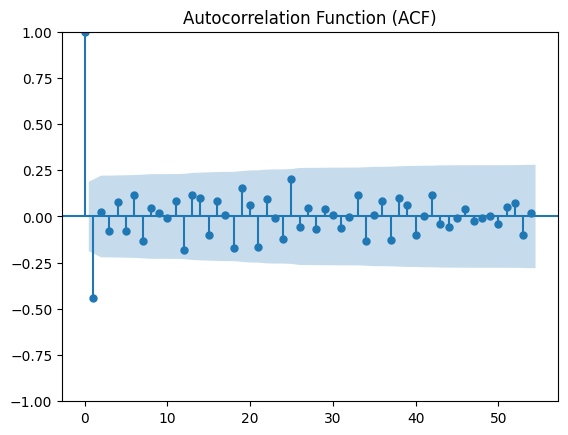

<Figure size 1200x600 with 0 Axes>

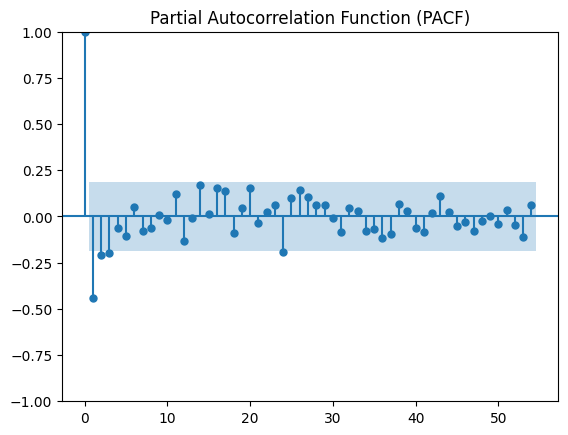


Fitting ARIMA model with order (4, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -644.427
Date:                Wed, 02 Apr 2025   AIC                           1306.854
Time:                        16:05:45   BIC                           1331.076
Sample:                             0   HQIC                          1316.677
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6077      0.197     -3.086      0.002      -0.994      -0.222
ar.L2          1.1377      0.125      9.066      0.000       0.892       1.3

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

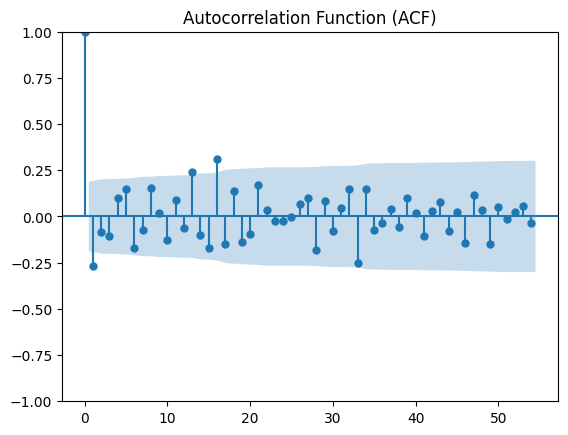

<Figure size 1200x600 with 0 Axes>

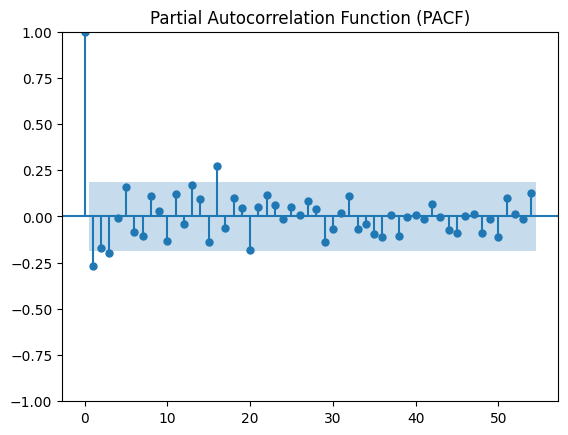


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -658.137
Date:                Wed, 02 Apr 2025   AIC                           1338.273
Time:                        16:05:47   BIC                           1367.878
Sample:                             0   HQIC                          1350.279
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1645      5.138      0.032      0.974      -9.906      10.235
ar.L2          0.3787      1.387      0.273      0.785      -2.339       3.0

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

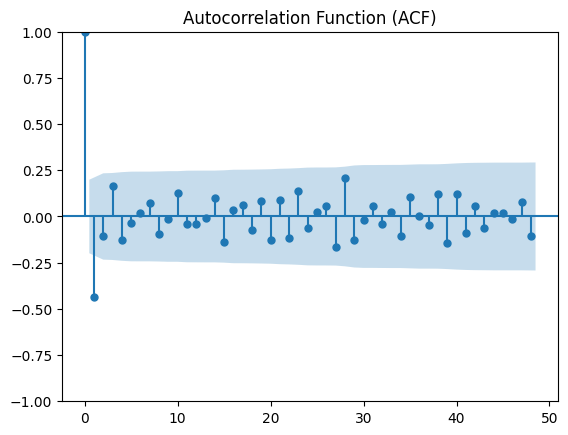

<Figure size 1200x600 with 0 Axes>

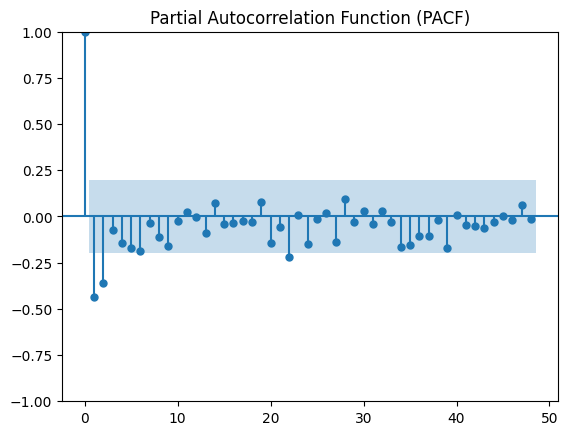


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   98
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -606.169
Date:                Wed, 02 Apr 2025   AIC                           1226.338
Time:                        16:05:48   BIC                           1244.361
Sample:                             0   HQIC                          1233.626
                                 - 98                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2551      0.114    -11.018      0.000      -1.478      -1.032
ar.L2         -0.9423      0.143     -6.567      0.000      -1.224      -0.6

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

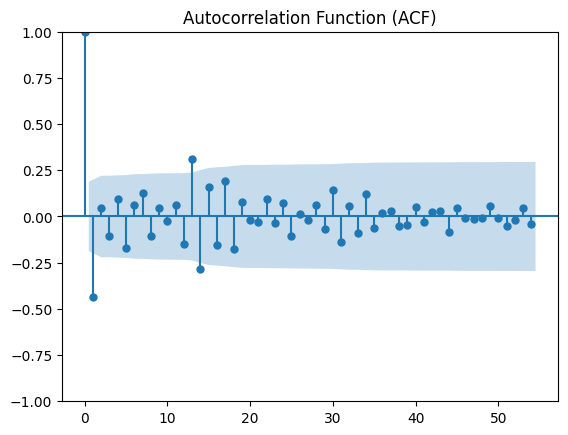

<Figure size 1200x600 with 0 Axes>

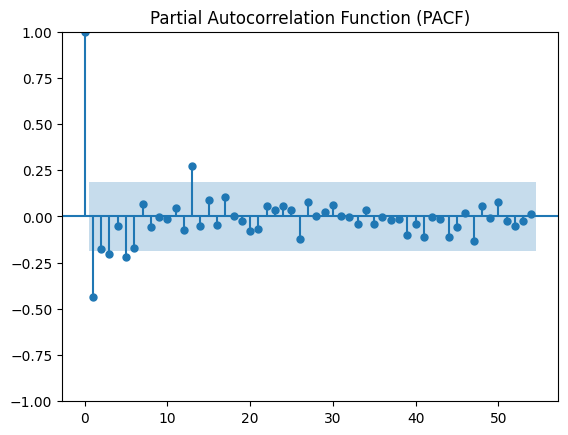


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -515.112
Date:                Wed, 02 Apr 2025   AIC                           1052.224
Time:                        16:05:49   BIC                           1081.829
Sample:                             0   HQIC                          1064.230
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1890      0.273      0.692      0.489      -0.347       0.725
ar.L2          0.1545      0.115      1.340      0.180      -0.071       0.3

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

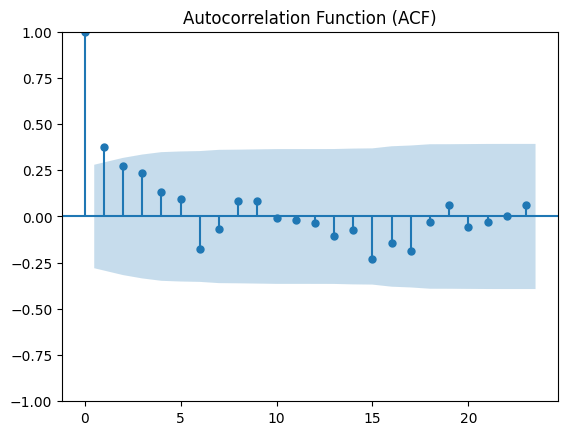

<Figure size 1200x600 with 0 Axes>

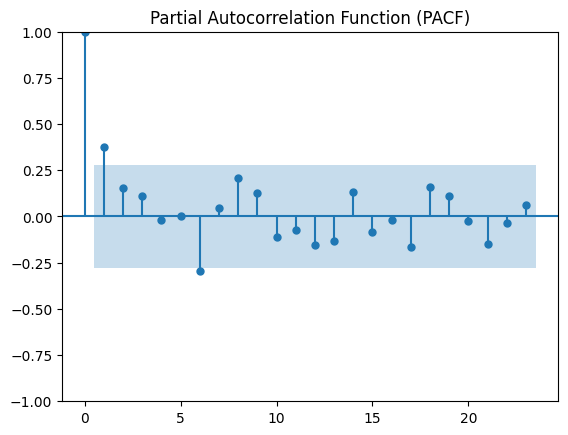


Fitting ARIMA model with order (4, 0, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   49
Model:                 ARIMA(4, 0, 1)   Log Likelihood                -291.373
Date:                Wed, 02 Apr 2025   AIC                            596.746
Time:                        16:05:50   BIC                            609.988
Sample:                             0   HQIC                           601.770
                                 - 49                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        580.0916     37.692     15.390      0.000     506.217     653.966
ar.L1          0.3825      6.755      0.057      0.955     -12.858      13.6

<Figure size 1200x600 with 0 Axes>

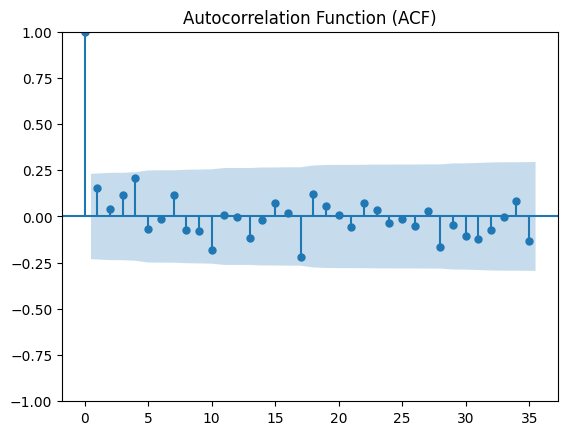

<Figure size 1200x600 with 0 Axes>

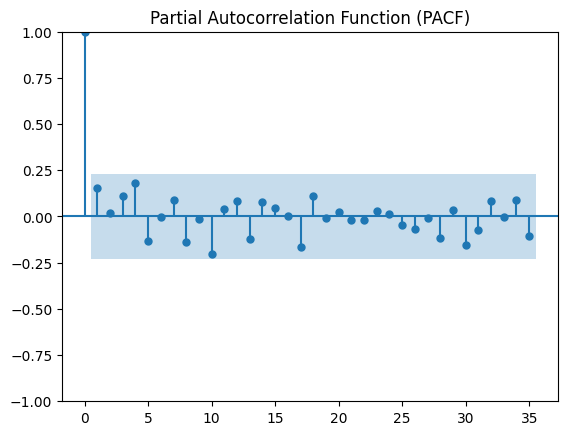


Fitting ARIMA model with order (5, 0, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   72
Model:                 ARIMA(5, 0, 2)   Log Likelihood                -418.632
Date:                Wed, 02 Apr 2025   AIC                            855.263
Time:                        16:05:52   BIC                            875.753
Sample:                             0   HQIC                           863.420
                                 - 72                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        755.9778     17.538     43.104      0.000     721.603     790.353
ar.L1         -1.4841      0.139    -10.670      0.000      -1.757      -1.2

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

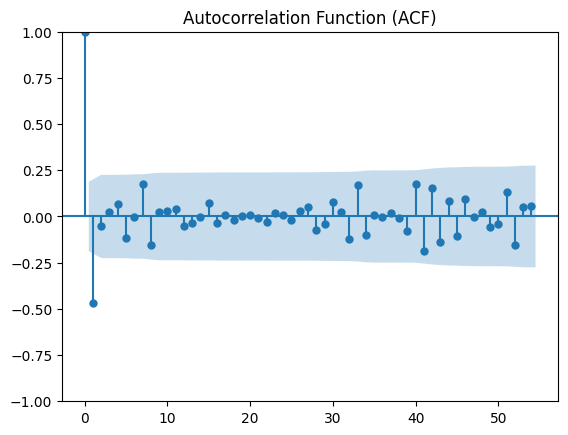

<Figure size 1200x600 with 0 Axes>

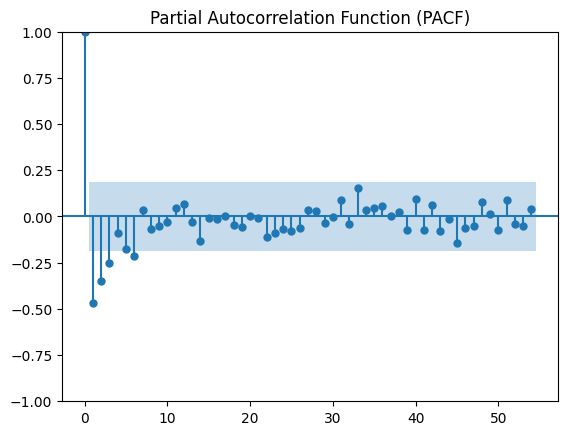


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -252.373
Date:                Wed, 02 Apr 2025   AIC                            518.747
Time:                        16:05:53   BIC                            537.586
Sample:                             0   HQIC                           526.387
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5005      0.124    -12.074      0.000      -1.744      -1.257
ar.L2         -0.9568      0.195     -4.909      0.000      -1.339      -0.5

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

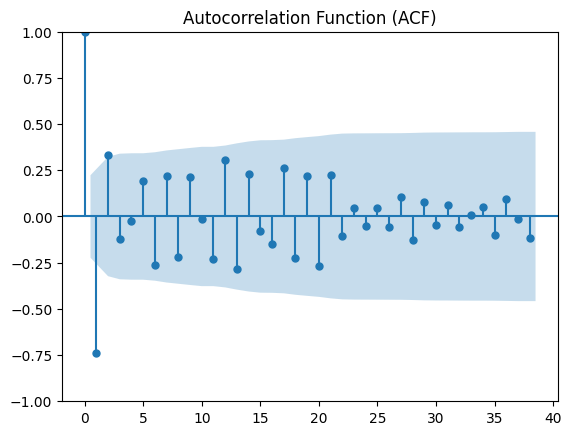

<Figure size 1200x600 with 0 Axes>

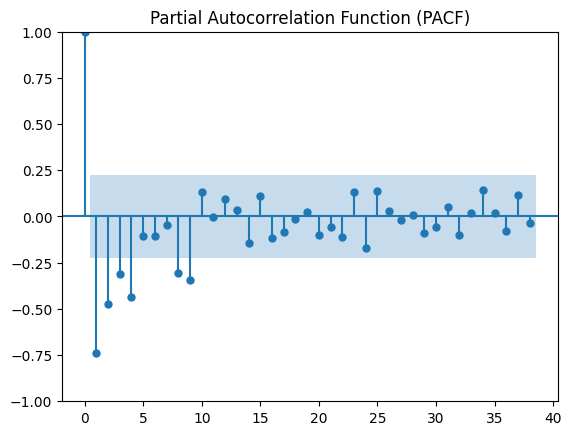


Fitting ARIMA model with order (5, 2, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   79
Model:                 ARIMA(5, 2, 5)   Log Likelihood                -135.215
Date:                Wed, 02 Apr 2025   AIC                            292.431
Time:                        16:05:54   BIC                            318.213
Sample:                             0   HQIC                           302.743
                                 - 79                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5398      0.206     -7.488      0.000      -1.943      -1.137
ar.L2         -1.5412      0.327     -4.708      0.000      -2.183      -0.9

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

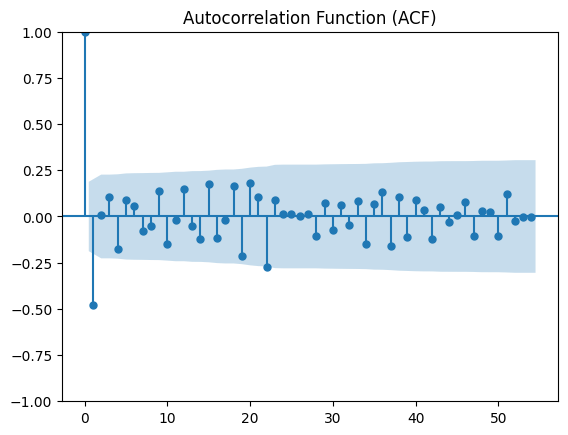

<Figure size 1200x600 with 0 Axes>

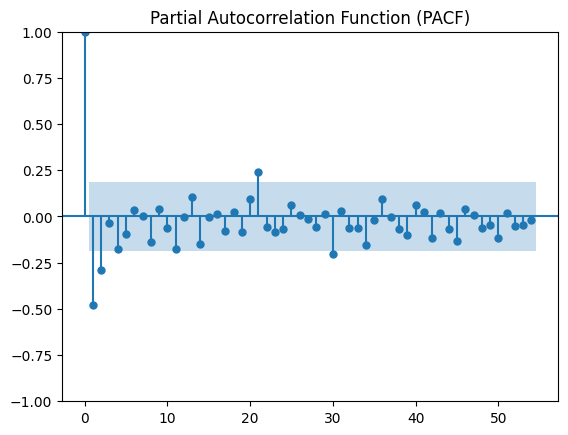


Fitting ARIMA model with order (4, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -249.584
Date:                Wed, 02 Apr 2025   AIC                            517.169
Time:                        16:05:56   BIC                            541.391
Sample:                             0   HQIC                           526.992
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2291      1.069     -0.214      0.830      -2.325       1.867
ar.L2         -0.2377      0.755     -0.315      0.753      -1.718       1.2

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

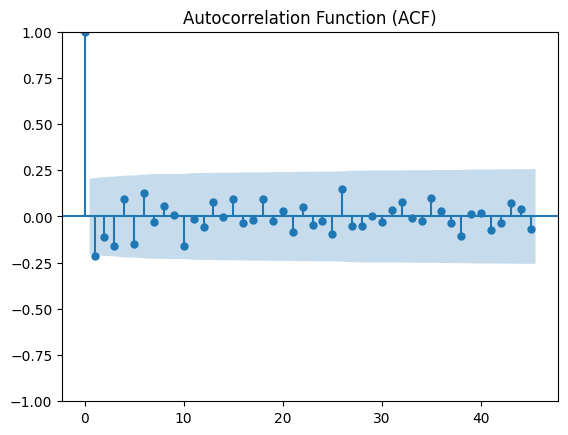

<Figure size 1200x600 with 0 Axes>

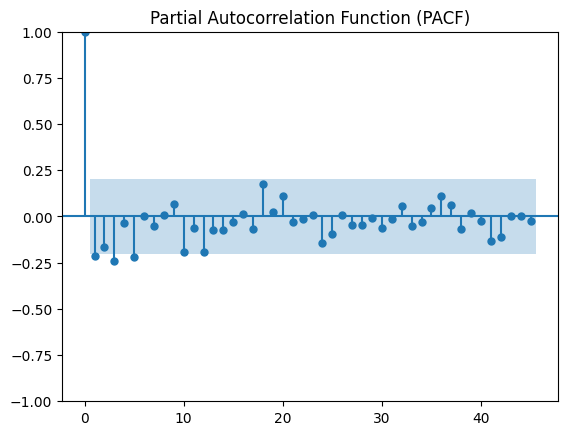


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   93
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -157.608
Date:                Wed, 02 Apr 2025   AIC                            337.216
Time:                        16:05:58   BIC                            364.956
Sample:                             0   HQIC                           348.412
                                 - 93                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3796      0.176      2.157      0.031       0.035       0.725
ar.L2          0.8660      0.149      5.803      0.000       0.574       1.1

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

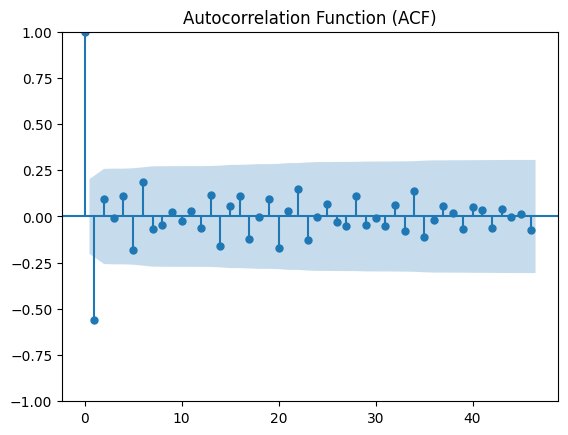

<Figure size 1200x600 with 0 Axes>

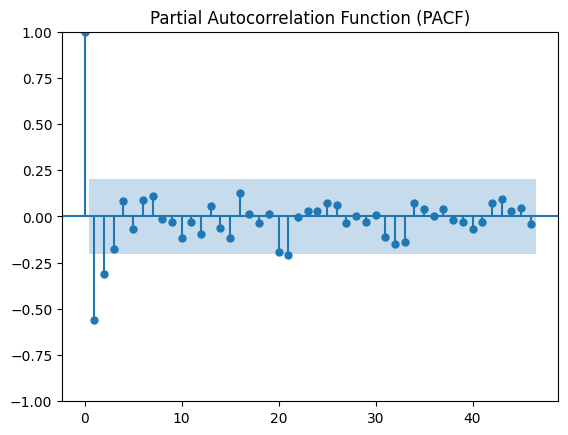


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   95
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -142.297
Date:                Wed, 02 Apr 2025   AIC                            298.593
Time:                        16:05:59   BIC                            316.396
Sample:                             0   HQIC                           305.785
                                 - 95                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3864      0.132    -10.530      0.000      -1.644      -1.128
ar.L2         -1.4216      0.109    -13.062      0.000      -1.635      -1.2

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

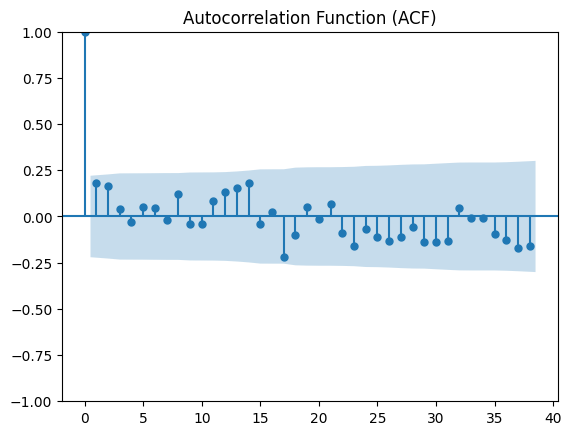

<Figure size 1200x600 with 0 Axes>

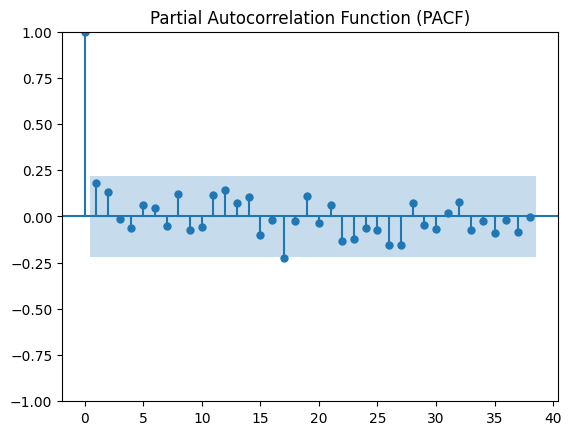


Fitting ARIMA model with order (2, 0, 1)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   79
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -511.148
Date:                Wed, 02 Apr 2025   AIC                           1032.296
Time:                        16:05:59   BIC                           1044.143
Sample:                             0   HQIC                          1037.042
                                 - 79                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1088.8652     27.075     40.216      0.000    1035.798    1141.932
ar.L1          0.1324      0.68

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for ચૂ્રણ saved as D:\APMC-price-predictor\ml_models\vegetables_saved_models\arima_model_53a8c445bbc876962de0afa269bc4b91.pkl
ઘીસોડા size:  106
True
Checking stationarity for the raw price data of ઘીસોડા:

ADF Test Results:
ADF Statistic: -4.4688
p-value: 0.0002
Critical Value 1%: -3.4942
Critical Value 5%: -2.8895
Critical Value 10%: -2.5817
The series is stationary (no further differencing needed).
Data is stationary with d=0.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -4.4688
p-value: 0.0002
Critical Value 1%: -3.4942
Critical Value 5%: -2.8895
Critical Value 10%: -2.5817
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 0 at lags []
Significant spikes in PACF (p): 2 at lags [ 9 19]


<Figure size 1200x600 with 0 Axes>

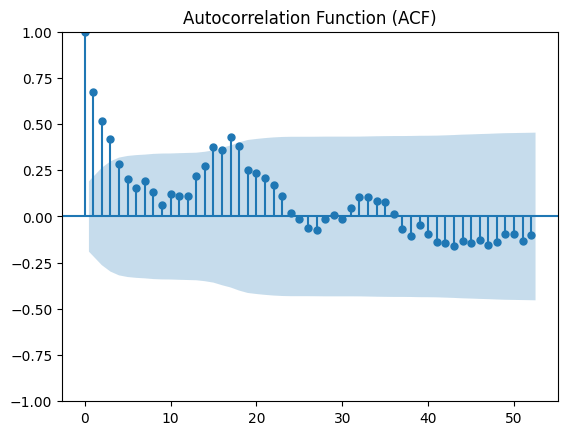

<Figure size 1200x600 with 0 Axes>

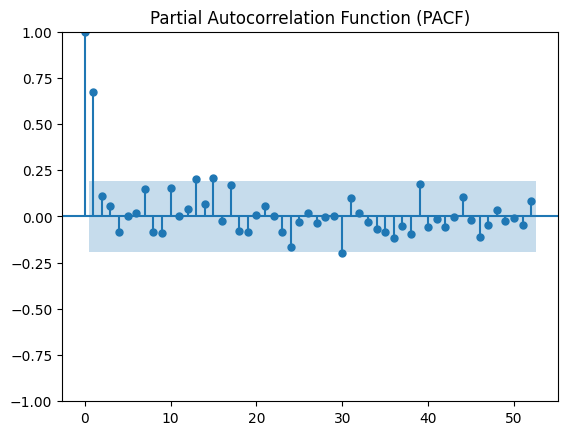


Fitting ARIMA model with order (2, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  106
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -667.123
Date:                Wed, 02 Apr 2025   AIC                           1342.245
Time:                        16:06:00   BIC                           1352.899
Sample:                             0   HQIC                          1346.563
                                - 106                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        625.8189     75.680      8.269      0.000     477.489     774.149
ar.L1          0.5499      0.06

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for ઘીસોડા saved as D:\APMC-price-predictor\ml_models\vegetables_saved_models\arima_model_6b3ba9b2b3bcd7fa9802edc58eec99e8.pkl
લીંબુ size:  110
True
Checking stationarity for the raw price data of લીંબુ:

ADF Test Results:
ADF Statistic: -0.7841
p-value: 0.8237
Critical Value 1%: -3.4942
Critical Value 5%: -2.8895
Critical Value 10%: -2.5817
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -8.5141
p-value: 0.0000
Critical Value 1%: -3.4942
Critical Value 5%: -2.8895
Critical Value 10%: -2.5817
The series is stationary (no further differencing needed).
Data is stationary with d=1.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -8.5141
p-value: 0.0000
Critical Value 1%: -3.4942
Critical Value 5%: -2.8895
Critical Value 10%: -2.5817
The series is stationary (no further differencing needed).
Significant spikes in ACF (q): 3 at lags [1 2 9]
Significant spikes in PACF (p): 10 at lags [ 1  2  3  4  5  6 14 15 

<Figure size 1200x600 with 0 Axes>

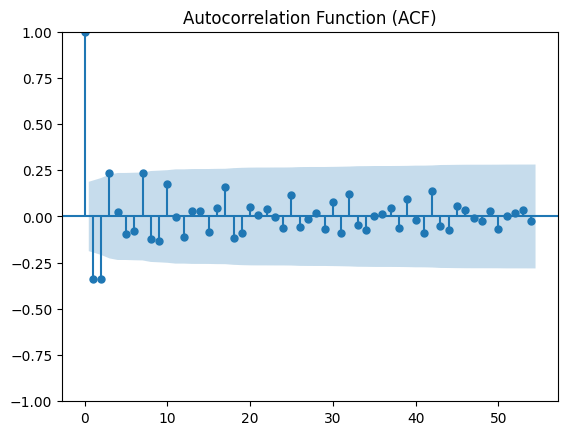

<Figure size 1200x600 with 0 Axes>

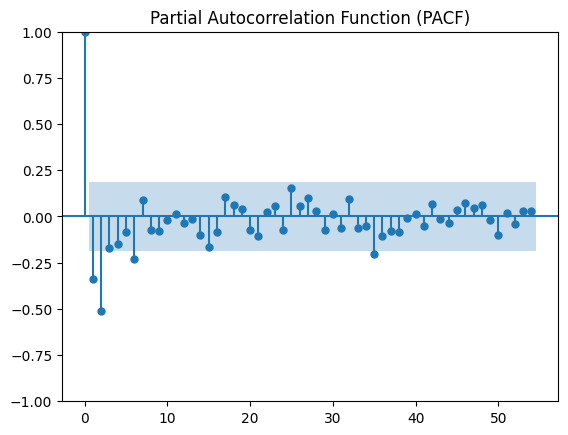


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -716.592
Date:                Wed, 02 Apr 2025   AIC                           1447.185
Time:                        16:06:02   BIC                           1466.024
Sample:                             0   HQIC                          1454.825
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2861      0.178      1.611      0.107      -0.062       0.634
ar.L2          0.8256      0.137      6.048      0.000       0.558       1.0

<Figure size 1200x600 with 0 Axes>

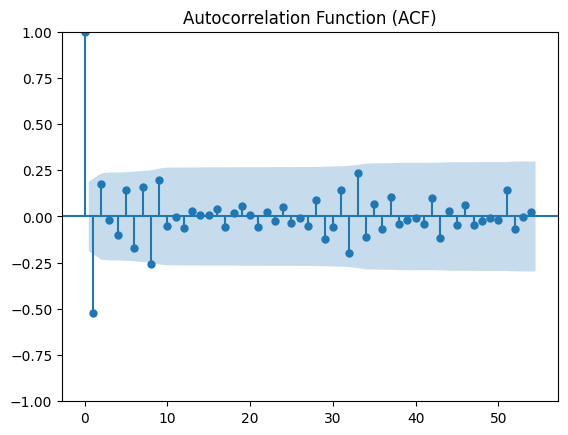

<Figure size 1200x600 with 0 Axes>

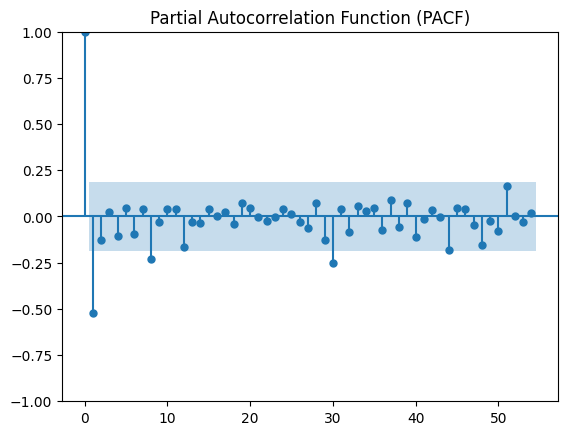


Fitting ARIMA model with order (3, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                 ARIMA(3, 1, 3)   Log Likelihood                -168.023
Date:                Wed, 02 Apr 2025   AIC                            350.046
Time:                        16:06:03   BIC                            368.886
Sample:                             0   HQIC                           357.686
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7337      0.508     -1.443      0.149      -1.730       0.263
ar.L2          0.5053      0.620      0.815      0.415      -0.710       1.7

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

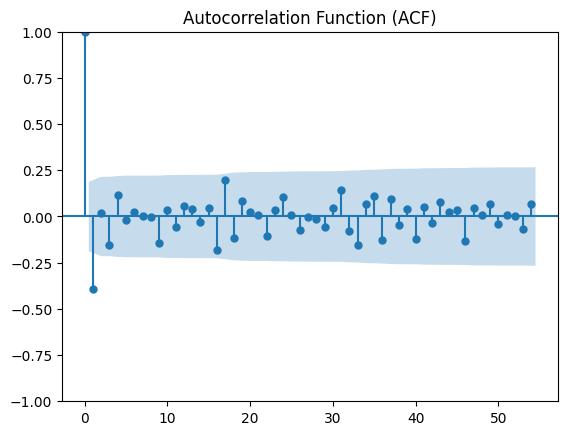

<Figure size 1200x600 with 0 Axes>

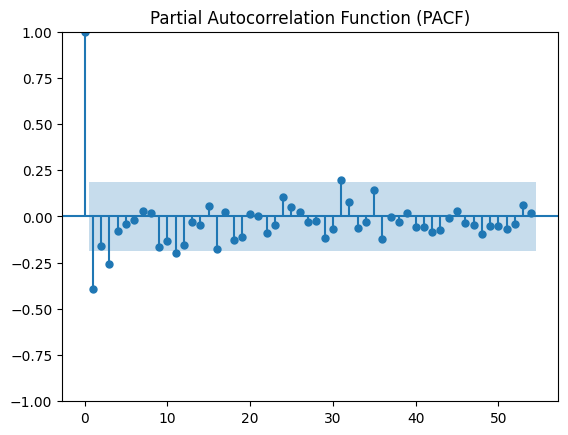


Fitting ARIMA model with order (4, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -277.375
Date:                Wed, 02 Apr 2025   AIC                            572.750
Time:                        16:06:04   BIC                            596.973
Sample:                             0   HQIC                           582.573
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1082      0.743     -0.146      0.884      -1.565       1.348
ar.L2         -0.2353      0.558     -0.422      0.673      -1.328       0.8

<Figure size 1200x600 with 0 Axes>

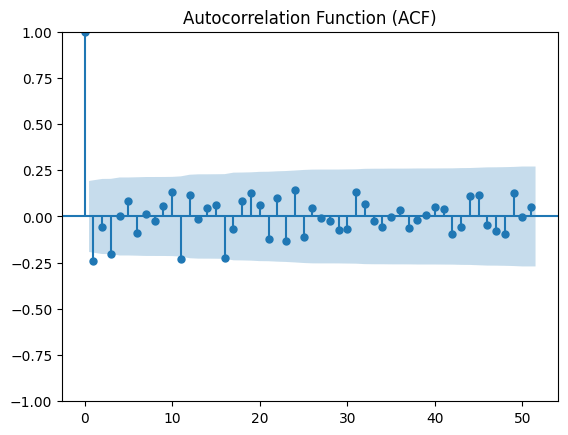

<Figure size 1200x600 with 0 Axes>

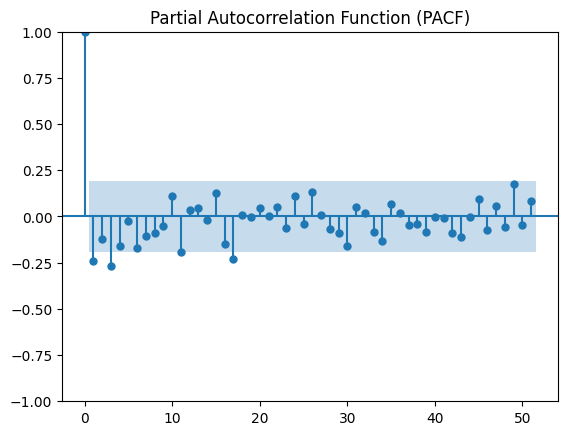


Fitting ARIMA model with order (4, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  105
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -290.612
Date:                Wed, 02 Apr 2025   AIC                            599.223
Time:                        16:06:07   BIC                            623.023
Sample:                             0   HQIC                           608.865
                                - 105                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0373      0.639      0.058      0.953      -1.216       1.290
ar.L2         -0.5278      0.368     -1.434      0.152      -1.249       0.1

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

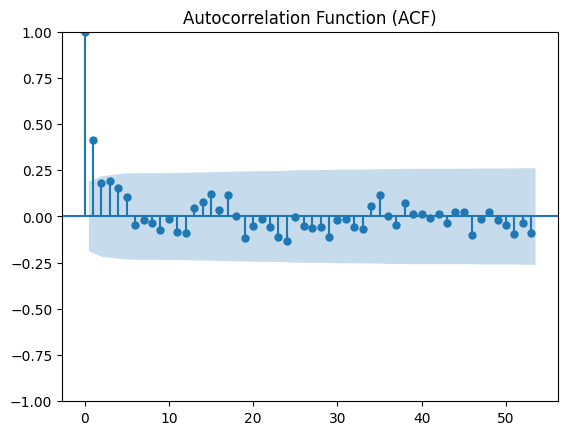

<Figure size 1200x600 with 0 Axes>

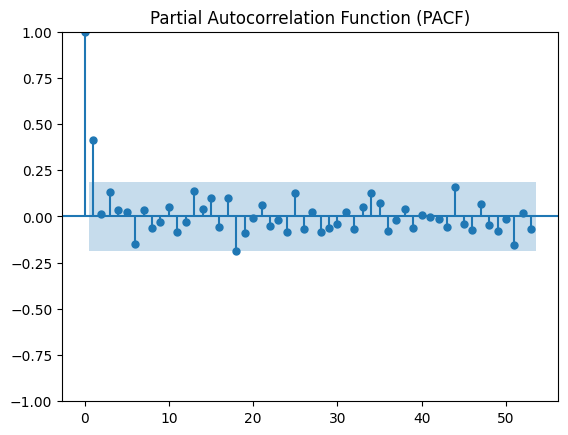


Fitting ARIMA model with order (4, 0, 0)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  109
Model:                 ARIMA(4, 0, 0)   Log Likelihood                -640.814
Date:                Wed, 02 Apr 2025   AIC                           1293.627
Time:                        16:06:08   BIC                           1309.775
Sample:                             0   HQIC                          1300.176
                                - 109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        569.5085     20.286     28.074      0.000     529.749     609.268
ar.L1          0.4351      0.116      3.757      0.000       0.208       0.6

<Figure size 1200x600 with 0 Axes>

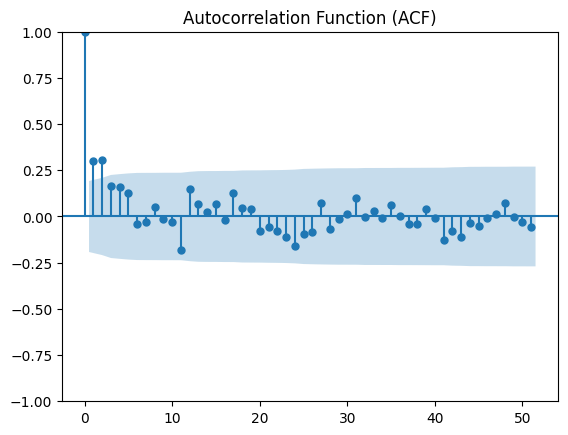

<Figure size 1200x600 with 0 Axes>

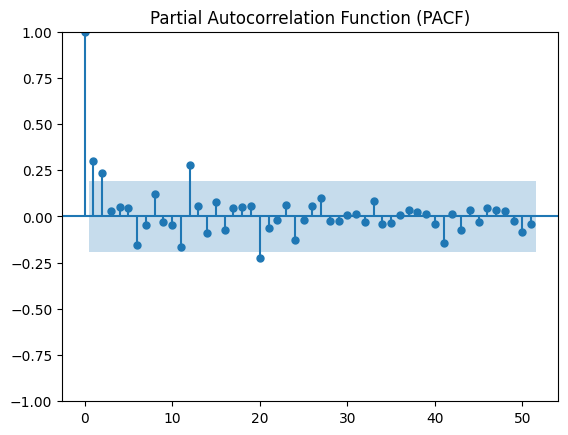


Fitting ARIMA model with order (4, 0, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  104
Model:                 ARIMA(4, 0, 1)   Log Likelihood                -615.793
Date:                Wed, 02 Apr 2025   AIC                           1245.586
Time:                        16:06:09   BIC                           1264.097
Sample:                             0   HQIC                          1253.085
                                - 104                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        551.3413     18.072     30.508      0.000     515.921     586.762
ar.L1          0.3108      1.977      0.157      0.875      -3.563       4.1

<Figure size 1200x600 with 0 Axes>

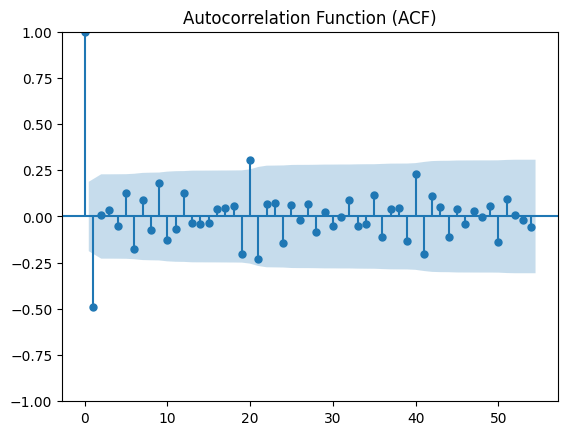

<Figure size 1200x600 with 0 Axes>

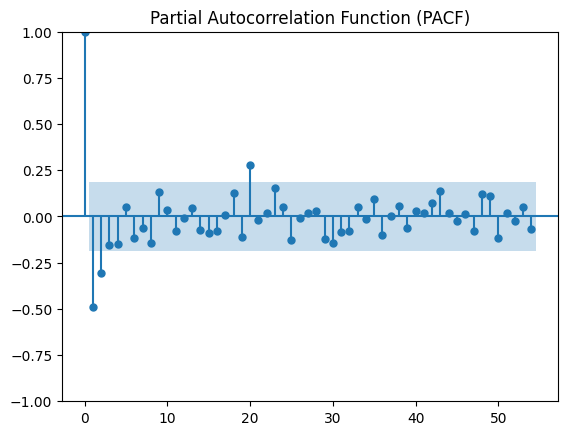


Fitting ARIMA model with order (4, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -677.595
Date:                Wed, 02 Apr 2025   AIC                           1373.189
Time:                        16:06:11   BIC                           1397.411
Sample:                             0   HQIC                          1383.012
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0662      0.278     -0.239      0.811      -0.610       0.478
ar.L2          0.0759      0.219      0.347      0.729      -0.353       0.5

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

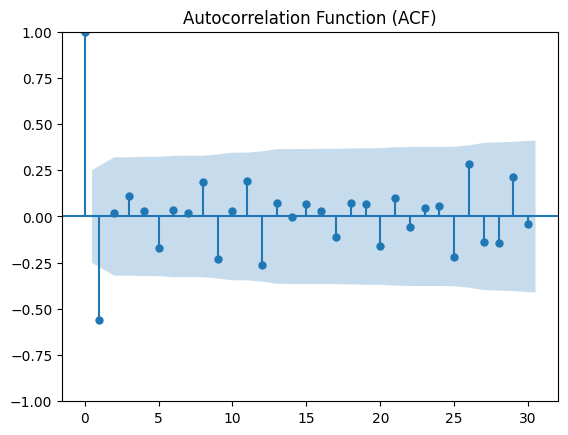

<Figure size 1200x600 with 0 Axes>

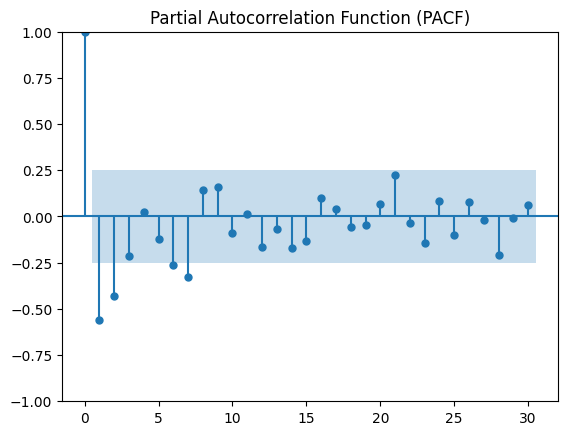


Fitting ARIMA model with order (4, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   62
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -313.621
Date:                Wed, 02 Apr 2025   AIC                            645.241
Time:                        16:06:12   BIC                            664.239
Sample:                             0   HQIC                           652.687
                                 - 62                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1441      1.315     -0.110      0.913      -2.722       2.433
ar.L2         -0.6591      0.304     -2.171      0.030      -1.254      -0.0

<Figure size 1200x600 with 0 Axes>

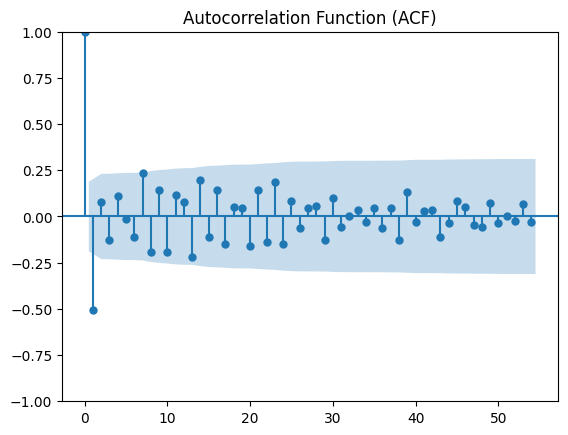

<Figure size 1200x600 with 0 Axes>

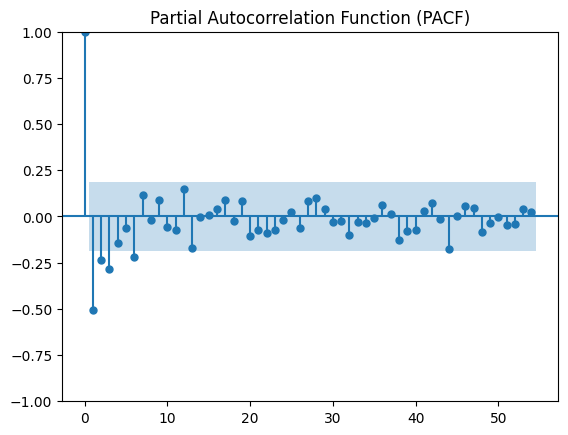


Fitting ARIMA model with order (5, 1, 5)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -611.065
Date:                Wed, 02 Apr 2025   AIC                           1244.131
Time:                        16:06:14   BIC                           1273.736
Sample:                             0   HQIC                          1256.137
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3241      0.217     -1.492      0.136      -0.750       0.102
ar.L2          0.6435      0.198      3.246      0.001       0.255       1.0

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

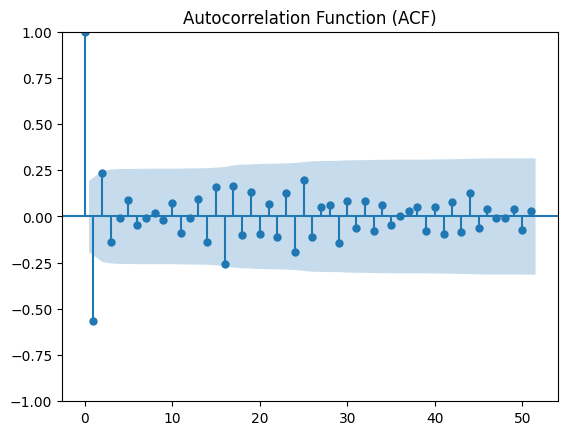

<Figure size 1200x600 with 0 Axes>

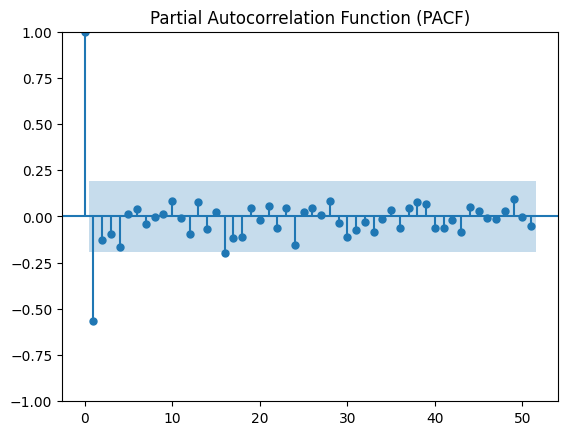


Fitting ARIMA model with order (4, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  105
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -527.372
Date:                Wed, 02 Apr 2025   AIC                           1072.744
Time:                        16:06:16   BIC                           1096.543
Sample:                             0   HQIC                          1082.386
                                - 105                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9508      1.000     -0.951      0.342      -2.910       1.009
ar.L2         -1.0268      0.159     -6.478      0.000      -1.337      -0.7

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

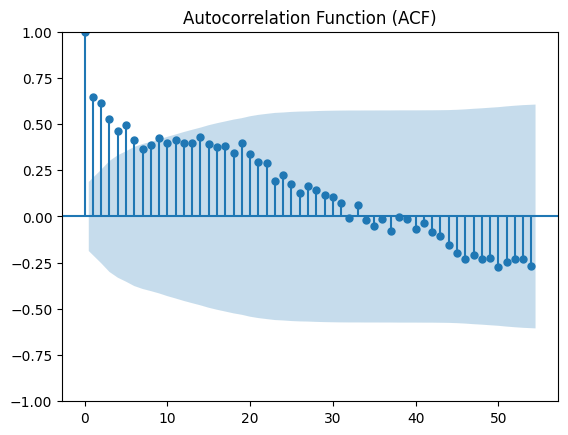

<Figure size 1200x600 with 0 Axes>

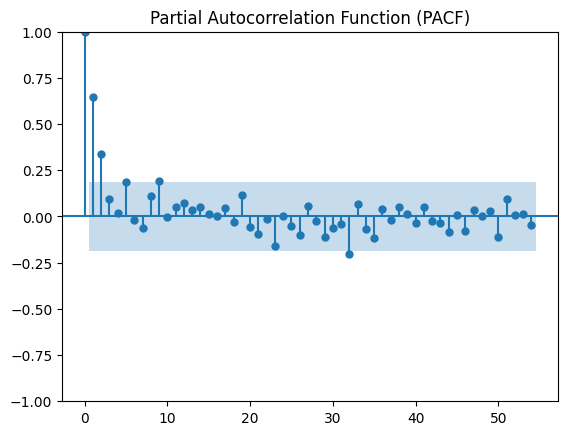


Fitting ARIMA model with order (0, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                          ARIMA   Log Likelihood                -370.645
Date:                Wed, 02 Apr 2025   AIC                            745.289
Time:                        16:06:16   BIC                            750.690
Sample:                             0   HQIC                           747.480
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.2318      0.831     26.760      0.000      20.604      23.860
sigma2        49.4577      7.63

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


<Figure size 1200x600 with 0 Axes>

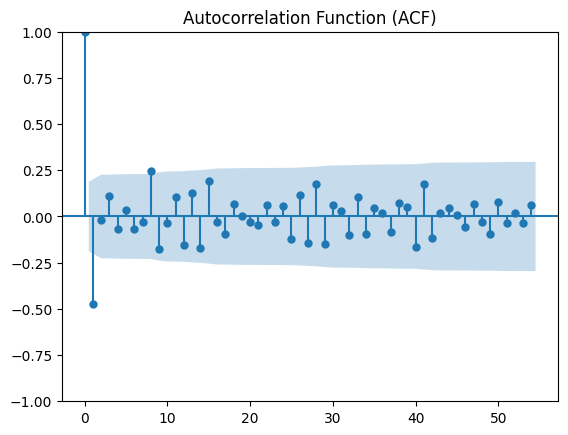

<Figure size 1200x600 with 0 Axes>

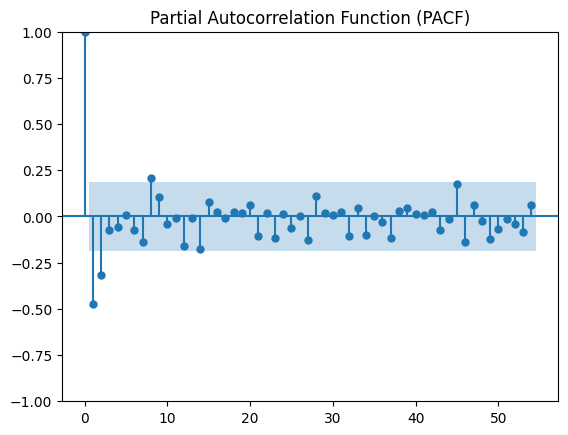


Fitting ARIMA model with order (5, 1, 4)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                  110
Model:                 ARIMA(5, 1, 4)   Log Likelihood                -162.296
Date:                Wed, 02 Apr 2025   AIC                            344.592
Time:                        16:06:18   BIC                            371.505
Sample:                             0   HQIC                           355.506
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3919      2.269     -0.173      0.863      -4.838       4.054
ar.L2         -0.5749      2.734     -0.210      0.833      -5.933       4.7

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

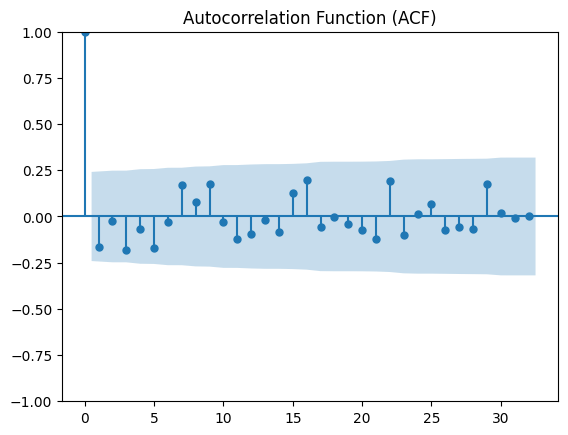

<Figure size 1200x600 with 0 Axes>

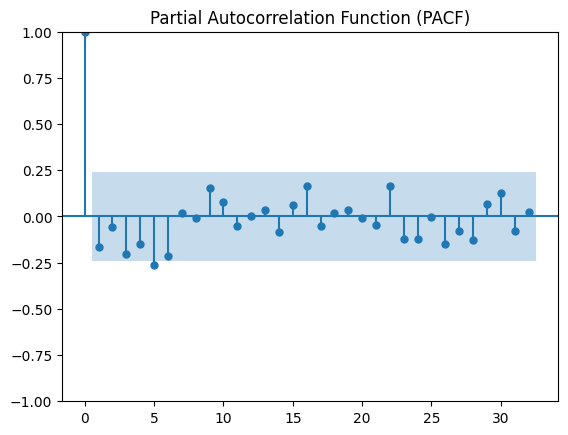


Fitting ARIMA model with order (5, 1, 3)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   67
Model:                 ARIMA(5, 1, 3)   Log Likelihood                -469.271
Date:                Wed, 02 Apr 2025   AIC                            956.541
Time:                        16:06:20   BIC                            976.248
Sample:                             0   HQIC                           964.329
                                 - 67                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0862      2.206     -0.039      0.969      -4.409       4.237
ar.L2          0.4705      1.735      0.271      0.786      -2.929       3.8

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

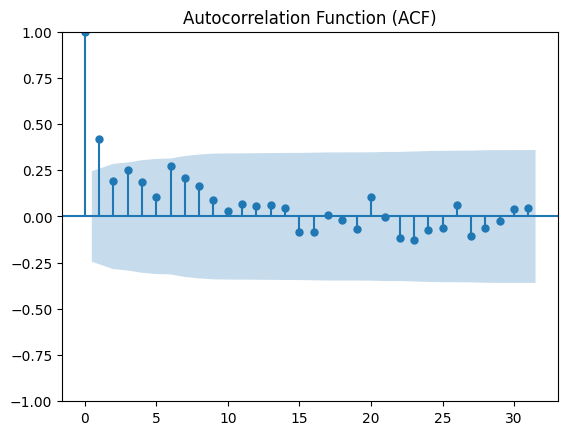

<Figure size 1200x600 with 0 Axes>

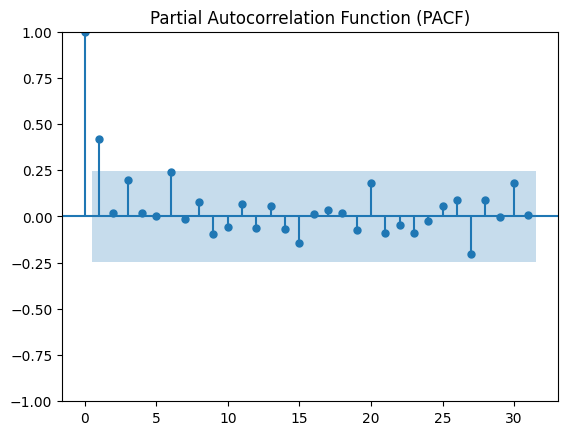


Fitting ARIMA model with order (1, 0, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   64
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -371.339
Date:                Wed, 02 Apr 2025   AIC                            748.677
Time:                        16:06:21   BIC                            755.154
Sample:                             0   HQIC                           751.229
                                 - 64                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        398.8250     18.142     21.984      0.000     363.268     434.382
ar.L1          0.4210      0.11

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


<Figure size 1200x600 with 0 Axes>

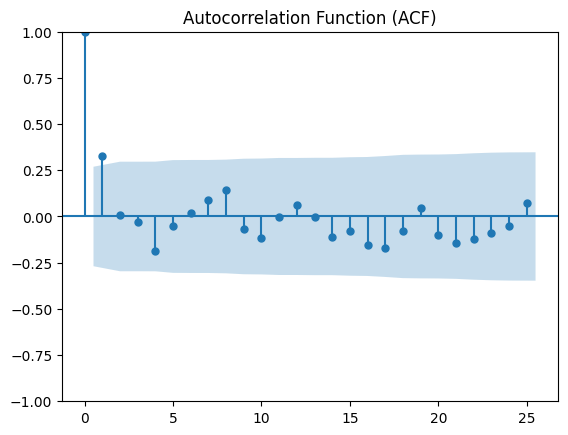

<Figure size 1200x600 with 0 Axes>

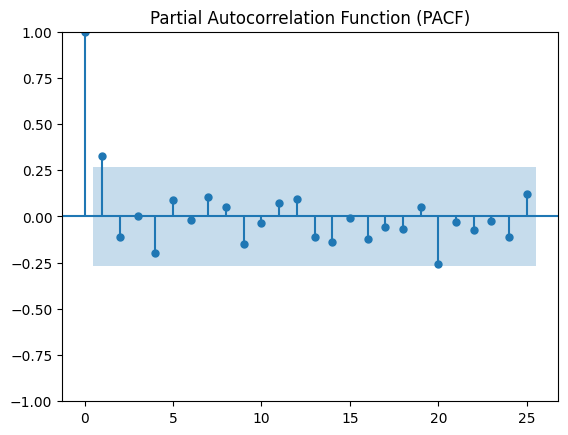


Fitting ARIMA model with order (5, 0, 2)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   53
Model:                 ARIMA(5, 0, 2)   Log Likelihood                -320.222
Date:                Wed, 02 Apr 2025   AIC                            658.444
Time:                        16:06:22   BIC                            676.176
Sample:                             0   HQIC                           665.263
                                 - 53                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        465.7943     19.575     23.795      0.000     427.428     504.161
ar.L1          0.0199     22.197      0.001      0.999     -43.486      43.5

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

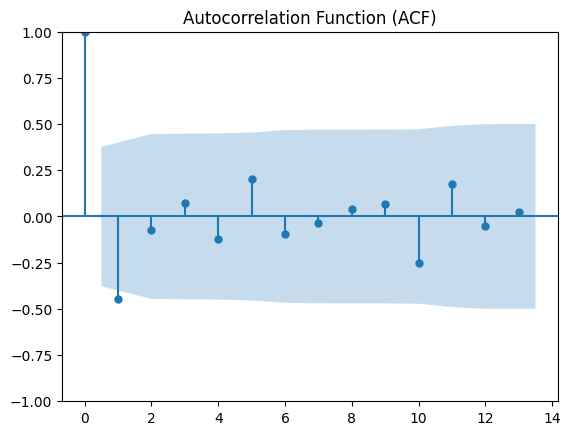

<Figure size 1200x600 with 0 Axes>

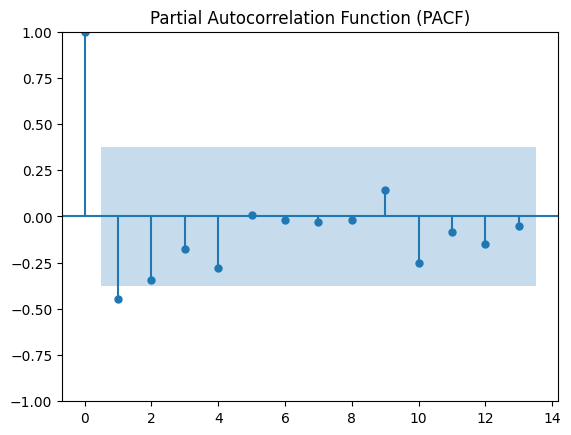


Fitting ARIMA model with order (2, 1, 2)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   28
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -194.253
Date:                Wed, 02 Apr 2025   AIC                            398.506
Time:                        16:06:22   BIC                            404.985
Sample:                             0   HQIC                           400.432
                                 - 28                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8112      0.514     -1.578      0.115      -1.819       0.196
ar.L2         -0.0951      0.33

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Model for ફણશી saved as D:\APMC-price-predictor\ml_models\vegetables_saved_models\arima_model_7e0ca41c93fb69a53e16a6d4af1e5b6c.pkl
parvar size:  10
False
Checking stationarity for the raw price data of parvar:

ADF Test Results:
ADF Statistic: -1.6776
p-value: 0.4427
Critical Value 1%: -4.9387
Critical Value 5%: -3.4776
Critical Value 10%: -2.8439
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -2.4012
p-value: 0.1414
Critical Value 1%: -5.3543
Critical Value 5%: -3.6462
Critical Value 10%: -2.9012
The series is not stationary (differencing is required).

ADF Test Results:
ADF Statistic: -4.8305
p-value: 0.0000
Critical Value 1%: -6.0451
Critical Value 5%: -3.9293
Critical Value 10%: -2.9868
The series is stationary (no further differencing needed).
Data is stationary with d=2.

Checking stationarity for the differenced data:

ADF Test Results:
ADF Statistic: -4.8305
p-value: 0.0000
Critical Value 1%: -6.0451
Critical Value 5%: -3.9293
Critica

<Figure size 1200x600 with 0 Axes>

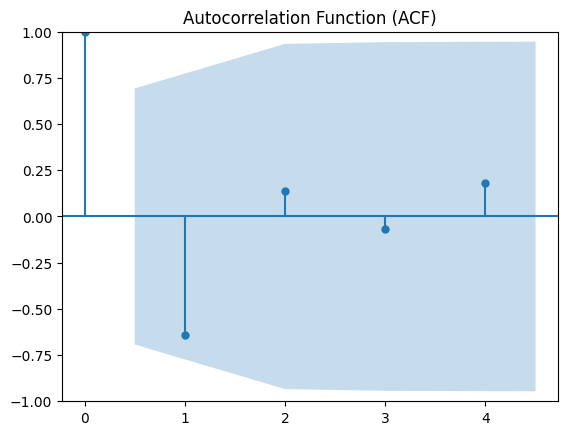

<Figure size 1200x600 with 0 Axes>

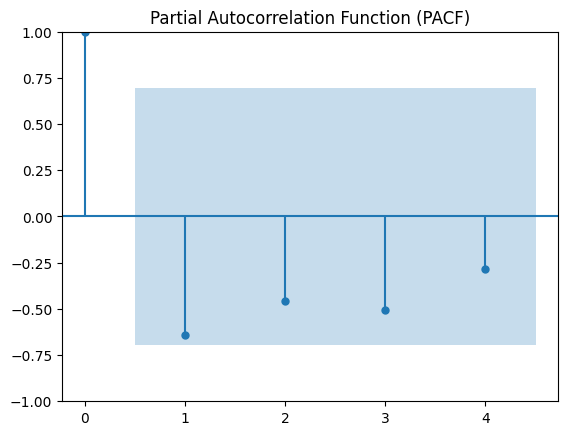


Fitting ARIMA model with order (3, 2, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   10
Model:                 ARIMA(3, 2, 1)   Log Likelihood                 -54.082
Date:                Wed, 02 Apr 2025   AIC                            118.164
Time:                        16:06:24   BIC                            118.562
Sample:                             0   HQIC                           115.485
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0428      1.615     -0.646      0.518      -4.207       2.122
ar.L2         -0.8389      2.099     -0.400      0.689      -4.953       3.2

<Figure size 1200x600 with 0 Axes>

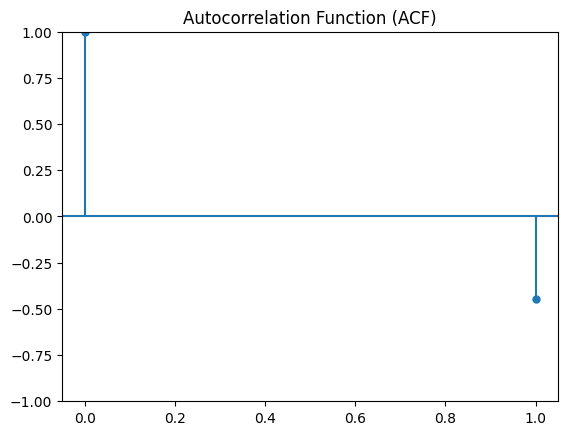

<Figure size 1200x600 with 0 Axes>

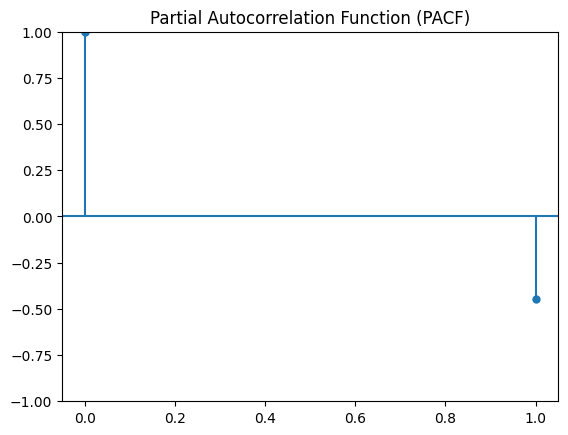


Fitting ARIMA model with order (1, 2, 0)...
ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                    5
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 -10.376
Date:                Wed, 02 Apr 2025   AIC                             24.752
Time:                        16:06:25   BIC                             22.949
Sample:                             0   HQIC                            21.128
                                  - 5                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0301      1.501     -0.020      0.984      -2.973       2.912
sigma2        59.0905    142.19

c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

<Figure size 1200x600 with 0 Axes>

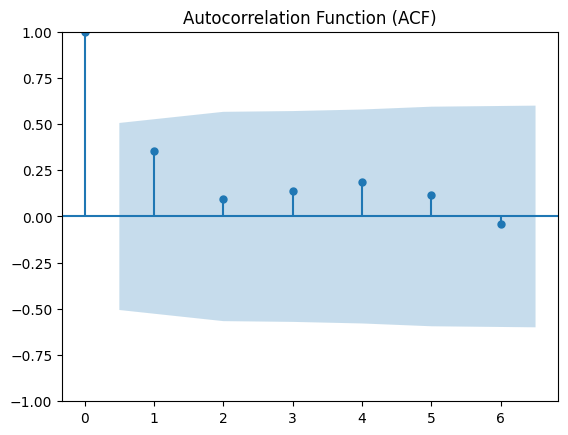

<Figure size 1200x600 with 0 Axes>

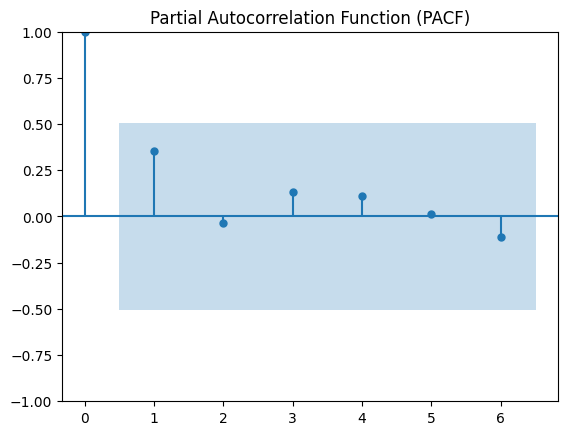


Fitting ARIMA model with order (0, 0, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   15
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 -88.020
Date:                Wed, 02 Apr 2025   AIC                            182.040
Time:                        16:06:26   BIC                            184.164
Sample:                             0   HQIC                           182.017
                                 - 15                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        166.8761     41.085      4.062      0.000      86.352     247.400
ma.L1          0.6354      0.209      3.046      0.002       0.227       1.0

<Figure size 1200x600 with 0 Axes>

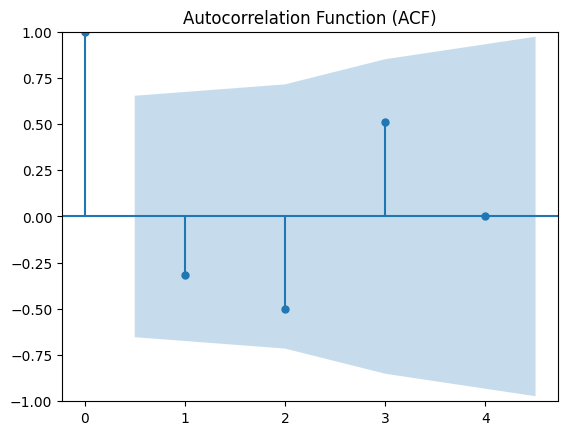

<Figure size 1200x600 with 0 Axes>

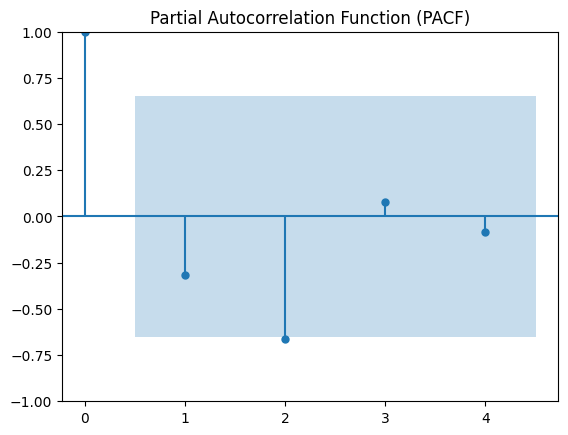


Fitting ARIMA model with order (2, 1, 1)...


c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\ladan\AppData\Local\Programs\Python\Python311\Lib

ARIMA model fitted successfully!

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:          Average Price   No. Observations:                   10
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 -60.067
Date:                Wed, 02 Apr 2025   AIC                            128.133
Time:                        16:06:30   BIC                            128.922
Sample:                             0   HQIC                           126.431
                                 - 10                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6532      0.278     -2.350      0.019      -1.198      -0.108
ar.L2         -0.7863      0.281     -2.801      0.005      -1.337      -0.2

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import csv
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from dateutil import rrule
from datetime import date
import time
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox, skew
from matplotlib import font_manager as fm
import os
import joblib
import hashlib
import csv
from dotenv import load_dotenv
load_dotenv()

products_with_boxcox = []


### removes data older than 4 months-----------------------------------------------------------------------------------------------
base_dir = Path(os.getenv("BASE_DIRECTORY"))
file_path = base_dir / "data/vegetables/vegetables_price_data.csv"
# csv_file = "commodities_price_data.csv"  # Update with your file path
save_dir = base_dir / "ml_models/vegetables_saved_models"
filename = base_dir / "ml_models/vegetables_saved_models/vegetables_parameters.csv"
allYearsFilename = base_dir / "data/vegetables/vegetables_price_data-all_years.csv"
os.makedirs(save_dir, exist_ok=True)
data = pd.read_csv(file_path, encoding='utf-8', parse_dates=['Date'], date_format='%d/%m/%Y')
print(data.head())
products = data['Item Name'].unique()
print(products)

# Get current date and calculate the cutoff date (4 months ago)
current_date = datetime.today()
cutoff_date = current_date - timedelta(days=4*30) # Approximate 4 months
cutoff_date = cutoff_date.replace(hour=0, minute=0, second=0, microsecond=0)

today_date = datetime.now().strftime("%d/%m/%Y")

# Filter data to keep only the last 4 months
filtered_data = data[pd.to_datetime(data["Date"], dayfirst=True) >= cutoff_date]

# Save the cleaned data back to CSV
filtered_data.to_csv(file_path, encoding='utf-8', index=False)

print(f"Data older than {cutoff_date.strftime('%d-%m-%Y')} has been removed.")

logs = []
###------------------------------------------------------------------------------------------------------------------------------

#function to get product parameters from csv
def get_product_parameters(filename, product_name):
    result = []
    
    # Open the CSV file
    with open(filename, mode='r', newline='', encoding='utf-8') as file:
        reader = csv.DictReader(file)  # Using DictReader to work with column headers
        for row in reader:
            if product_name in row['Item Name']:  # Check if product_name matches
                result.append({
                    'Date': row['Date'],
                    'Item Name': row['Item Name'],
                    'p': row['p'],
                    'd': row['d'],
                    'q': row['q']
                })
    
    return result


#function to update arima model parameters
def update_product_parameters(csv_file, today_date, product_name, p, d, q):
    # Read the existing CSV into a list of rows
    rows = []
    header = []
    
    # Open the CSV to read its current data
    if os.path.exists(csv_file):
        with open(csv_file, mode='r', newline='', encoding='utf-8') as file:
            reader = csv.reader(file)
            # Read the header and the rest of the rows
            header = next(reader)  # The first row is the header
            rows = list(reader)  # The rest of the rows are the data
    else:
        # If the file doesn't exist, we initialize an empty list for rows
        rows = []
    
    # Flag to check if the product is found
    product_found = False
    
    # Iterate through the rows and update the (p, d, q) values if the product is found
    for i, row in enumerate(rows):
        if row[1] == product_name:  # Assuming the 'Item Name' is in the second column (index 1)
            rows[i] = [today_date, product_name, p, d, q]  # Update the row with new values
            product_found = True
            message = f"Updated {product_name} with new (p, d, q): ({p}, {d}, {q})"
            # print(message)
            logs.append(message)
            break
    
    # If the product was not found, append it as a new entry
    if not product_found:
        rows.append([today_date, product_name, p, d, q])  # Add a new row for the product
        message = f"Added new item {product_name} with (p, d, q): ({p}, {d}, {q})"
        # print(message)
        logs.append(message)
    
    # Write the updated data back to the CSV
    with open(csv_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        # Write the header first
        writer.writerow(header)
        # Write all the rows (updated or new)
        writer.writerows(rows)



###Saving updated ARIMA models---------------------------------------------------------------------------------------------------

# Step 1: Stationarity Check
def check_stationarity(series, size):
    if len(series) == size:
        return True
    result = adfuller(series)
    print("\nADF Test Results:")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"Critical Value {key}: {value:.4f}")
    if result[1] < 0.05:
        print("The series is stationary (no further differencing needed).")
        return True
    else:
        print("The series is not stationary (differencing is required).")
        return False

# Function to count significant lags
def count_significant_spikes(values, confint):
    # The significant lags are those outside the confidence interval
    significant_lags = np.where(np.abs(values) > confint[:, 1])[0]
    return len(significant_lags), significant_lags

# Function to generate a safe file name
def safe_filename(product_name):
    return hashlib.md5(product_name.encode('utf-8')).hexdigest()





###updating the csv with current data---------------------------------------------------------------------------------------------

def write_to_csv(data, filename):
    # Define the field names for the CSV file
    # fieldnames = ['Serial Number', 'Date', 'Item Name', 'Low Price', 'Average Price', 'High Price']
    
    # Write data to CSV file
    with open(filename, mode='a', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        
        # Write header row
        # writer.writerow(fieldnames)
        
        # Write data rows
        for _, row_data in enumerate(data):
            date = row_data[0]
            item_name = row_data[2]
            low_price = row_data[3]
            avg_price = row_data[5]
            high_price = row_data[4]
            writer.writerow([date, item_name, low_price, avg_price, high_price])
            
            
def getData(driver, csv_file_name, webpage_path, date_path, submit_button_path, table_path):
    
    # add_field_names_price(csv_file_name)
    
    #iterate over all the dates    
    try:
        # Open the webpage
        driver.get(webpage_path)
            
        # Find the date input element
        date_input = driver.find_element(By.XPATH, date_path)

        # Clear any existing text in the date input field
        date_input.clear()
          
        # Enter the desired date
        date_input.send_keys(current_date.strftime('%d-%m-%Y'))  # Example date, replace with your desired date

        # Find and click the button to get data for the specified date
        submit_button = driver.find_element(By.XPATH, submit_button_path)
        submit_button.click()
         
        time.sleep(3) #to load data

        #Extract the table data
        table = driver.find_element(By.XPATH, table_path)
        # print(table)
        data = []

        # Iterate over each row in the table
        for row in table.find_elements(By.TAG_NAME, "tr"):
            # Find all cells (td) in the row
            cells = row.find_elements(By.TAG_NAME, "td")
                
            # Ensure that there are cells in the row
            if cells:
                # Extract text from each cell and append to the data list
                row_data = [current_date.strftime('%d-%m-%Y')] + [cell.text.strip() for cell in cells]
                data.append(row_data)

        # Print the extracted data for debugging
        # for row in data:
        #     print(row)
        write_to_csv(data, csv_file_name)
        write_to_csv(data, allYearsFilename)
        time.sleep(2)
        # return data
            
    except Exception as e:
        print(e)
        pass


def main():
    # Initialize Chrome WebDriver
    driver = webdriver.Chrome()

    # commodities_data_table = 
    getData(driver, file_path, os.getenv("VEGETABLES_WEBPAGE_PATH"),
                                            os.getenv("VEGETABLES_DATE_PATH"),
                                            os.getenv("VEGETABLES_SUBMIT_BUTTON_PATH"),
                                            os.getenv("VEGETABLES_TABLE_PATH"))
    
    time.sleep(5)
    
    # Close the WebDriver
    driver.quit()
    
    
    
    ###Updating models------------------------------------------------------------------------------------------------------------
    
    for product in products:
    
        product_name = product 
        product_data = data[data['Item Name'] == product_name]
        size_product_data = product_data.shape[0]
        print(product_name, "size: ", size_product_data)
        
        if((size_product_data//2)-1 <= 0):
            continue
        
        # Check if any data exists for the selected product
        if product_data.empty:
            print(f"No data found for the product: {product_name}")

        else:
            # Extract the 'Average Price' column for the selected product
            price_data = product_data['Average Price']
            # price_data.index = pd.to_datetime(price_data.index, format='%d-%m-%Y')
            # Get the last date in the dataset
            # latest_date = price_data.index.max()
            #print(latest_date)

            # Calculate the start date for the last 3 months
            # three_months_ago = latest_date - pd.DateOffset(months=3)
            #print(three_months_ago)

            # Filter the data for plotting
            # filtered_data = price_data[price_data.index >= three_months_ago]
            #print(filtered_data)


            # Plot the raw price data for the selected commodity
            # plt.figure(figsize=(12, 6))
            # plt.plot(price_data.index, price_data, label=f'{commodity_name} Prices', marker='o', linestyle='-')
            # plt.title(f'Price Trend for {commodity_name}')
            # plt.xlabel('Date')
            # plt.ylabel('Average Price')
            # plt.xticks(rotation=90)
            # plt.legend()
            # plt.grid()
            # plt.tight_layout()
            # plt.show()
            
        variance_ratio = price_data.std() / price_data.mean()
        skewness = skew(price_data)

        if variance_ratio > 0.1 and skewness > 0.5:
            apply_boxcox = True
            products_with_boxcox.append(product_name)
        else:
            apply_boxcox = False
        
        
        print(apply_boxcox)
        # Step 2: Differencing (if necessary)
        print(f"Checking stationarity for the raw price data of {product_name}:")
        d = 0
        price_diff = price_data
        
        try:
            if apply_boxcox:
                price_diff, lam = boxcox(price_diff)
                price_diff = pd.Series(price_diff)
        
            while True:
                if check_stationarity(price_diff, (size_product_data//2)+1):
                    # price_diff = price_data
                    print(f"Data is stationary with d={d}.")
                    break
                else:
                    price_diff = price_diff.diff().dropna()
                    d += 1
        
        # if check_stationarity(price_data):
        #   price_diff = price_data
        # else:
        #   price_diff = price_data.diff().dropna()  # Apply differencing to make the series stationary

            print("\nChecking stationarity for the differenced data:")
            check_stationarity(price_diff, (size_product_data//2)+1)
        
        except Exception as e:
            print(f"Stationarity cannot be applicable for {product_name}")
        # print(d)

        # filtered_price_diff = price_diff[price_diff.index >= three_months_ago]  # For differenced data

        # Plot the differenced data
        # plt.figure(figsize=(12, 6))
        # plt.plot(price_diff, label='Differenced Data', marker='o', linestyle='-')
        # plt.title('Differenced Data')
        # plt.xlabel('Date')
        # plt.ylabel('Price Difference')
        # plt.xticks(rotation=90)
        # plt.legend()
        # plt.grid()
        # plt.show()
        
        
        # Step 3: Plot ACF and PACF

        acf_values, acf_confint = acf(price_diff, alpha=0.05)
        pacf_values, pacf_confint = pacf(price_diff, alpha=0.05)


        # Count significant spikes for ACF (q)
        q, significant_acf_lags = count_significant_spikes(acf_values, acf_confint)

        # Count significant spikes for PACF (p)
        p, significant_pacf_lags = count_significant_spikes(pacf_values, pacf_confint)

        print(f"Significant spikes in ACF (q): {q} at lags {significant_acf_lags}")
        print(f"Significant spikes in PACF (p): {p} at lags {significant_pacf_lags}")

        # ACF and PACF Plots
        try:
            plt.figure(figsize=(12, 6))
            plot_acf(price_diff, lags=(size_product_data//2)-1, title="Autocorrelation Function (ACF)")
            plt.show()

            plt.figure(figsize=(12, 6))
            plot_pacf(price_diff, lags=(size_product_data//2)-1, title="Partial Autocorrelation Function (PACF)")
            plt.show()
        
        except Exception as e:
            print(f"Can't plot the acf/pacf plots for {product_name} due to {e}")

        # Explanation:
        # - ACF (Autocorrelation Function): Measures the correlation between a series and its lagged values.
        # - PACF (Partial Autocorrelation Function): Measures the correlation between a series and its lagged values,
        #   removing the influence of intermediate lags.
        # - Use these plots to decide on p (AR term) and q (MA term).
        
        if p > 5:
            p = min(5, q)
        if q > 5: 
            q = min(5, p)
        if d > 3:
            d = 1

        fit_successful = False

        while not fit_successful and q >= 0:
            try:
                print(f"\nFitting ARIMA model with order ({p}, {d}, {q})...")
                model = ARIMA(price_data, order=(p, d, q))
                model_fit = model.fit()
                fit_successful = True  
                print("ARIMA model fitted successfully!")
                
            except np.linalg.LinAlgError as err:
                print(f"Error encountered: {err}")
                if q > 0: 
                    q -= 1
                    print(f"Reducing q to {q} and trying again...")
                else:
                    print("Unable to fit model after reducing q multiple times. Exiting loop.")
                    break  
        
        
        # Step 5: Analyze Model Summary
        print("\nARIMA Model Summary:")
        print(model_fit.summary())
        
        
        product_parameters = get_product_parameters(filename, product_name)
        
        for item in product_parameters:
            p = item['p']
            d = item['d']
            q = item['q']
            
        update_product_parameters(filename, today_date, product_name, p, d, q)
        
        # with open(filename, mode='a', newline='', encoding='utf-8') as file:
        #     writer = csv.writer(file)
            
        #     # Write header row
        #     # writer.writerow(fieldnames)
        
        #     writer.writerow([today_date, product_name, p, d, q])
        
        
        try:
            # Assume model_fit is the fitted ARIMA model for this product
            hashed_name = safe_filename(product)
            model_filename = os.path.join(save_dir, f"arima_model_{hashed_name}.pkl")
            joblib.dump(model_fit, model_filename)
            print(f"Model for {product} saved as {model_filename}")
        except Exception as e:
            print(f"Error saving model for {product}: {e}")


if __name__ == "__main__":
    main()
